In [1]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 6 seconds

LOAD DURATION: 0:00:01.394928


In [2]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 1.88 s, sys: 412 ms, total: 2.29 s
Wall time: 2.46 s


(1070994, 32)

In [3]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [4]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some benign properties that we aren't interested in
There are certainly better ways to do this, and this important step can/should be improved.

In [5]:
# first look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(20).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [6]:
# remove some of these and add some others to also be removed
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list.append('NY STATE PUBLIC WORKS')
remove_list.append('NYC DEPT OF HIGHWAYS')
remove_list.append("NYC DEP'T OF HIGHWAYS")
remove_list.append('CITY WIDE ADMINISTRAT')
remove_list.append('DEPT OF PUBLIC WORKS')
remove_list.append('NEW YORK CITY')
remove_list.append('THE PORT OFNY & NJ')
remove_list.append('NYC DEPT OF PUB WORKS')
remove_list.append('NEW YORK STATE DEPART')
remove_list.append('CITY AND NON-CITY OWN')

In [7]:
property_data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
property_data.shape

(1046516, 32)

In [8]:
data.shape

(1070994, 32)

In [9]:
# of record removed
len(data) - len(property_data)

24478

In [10]:
numrecs = len(property_data)

## Fill in missing ZIP

In [11]:
# Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21537

In [12]:
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [13]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10114

In [14]:
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [15]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

The modifications include:

Replacing 'NaN' with np.nan to properly represent missing values.
Using the fillna() method to replace missing values with NaN.
Using the transform() method to compute the mean by tax class for each column.
Using isna() instead of checking for zero values to detect missing values.

Replacing missing values with the corresponding statistically smoothed mean for each tax class

In [16]:
property_data['TAXCLASS'].value_counts()

1     660106
2     179896
4      97317
2A     40510
1A     21666
1B     19002
2B     13856
2C     10789
3       2399
1C       946
1D        29
Name: TAXCLASS, dtype: int64

In [20]:
# Replace NaN with 0s
property_data['FULLVAL'].replace('NaN',0)

# Compute mean by tax class for FULLVAL
mean_fullval = property_data.groupby('TAXCLASS')['FULLVAL'].transform(lambda x: x.mean())

# Apply statistical smoothing to FULLVAL


def stats_smooth(c=10,nmid=50,col='FULLVAL',by_col='TAXCLASS'):
    temp =property_data[property_data[col]!=0]
    y_avg = temp[col].mean()
    print(y_avg)
    y_tax = temp.groupby(by_col)[col].mean()
    print(y_tax)
    num = temp.groupby(by_col).size()
    print(num)
    y_tax_smooth = y_avg + (y_tax - y_avg)/(1+np.exp(-(num-nmid)/c))
    print(y_tax_smooth)
    return y_tax_smooth

y_tax_smooth_fullval=stats_smooth(col='FULLVAL')

822706.5231597371
TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     8.510005e+04
4     2.713604e+06
Name: FULLVAL, dtype: float64
TAXCLASS
1     659723
1A     21663
1B     18611
1C       944
1D        29
2     173742
2A     40423
2B     13755
2C     10787
3         22
4      96172
dtype: int64
TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    3.169754e+06
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     7.804238e+05
4     2.713604e+06
dtype: float64


In [21]:


# Replace NaN with NaN
property_data['AVLAND'].replace('NaN',0)

# Compute mean by tax class for AVLAND
mean_avland = property_data.groupby('TAXCLASS')['AVLAND'].transform(lambda x: x.mean())

# Apply statistical smoothing to AVLAND
y_tax_smooth_avland=stats_smooth(col='AVLAND')



67695.96939284794
TAXCLASS
1      14901.810481
1A      2247.472465
1B      9177.301542
1C      8225.658898
1D    709303.793103
2      88471.102578
2A     31370.740197
2B     54607.394911
2C     25638.080660
3      28135.636364
4     440646.291155
Name: AVLAND, dtype: float64
TAXCLASS
1     659723
1A     21663
1B     18611
1C       944
1D        29
2     173741
2A     40423
2B     13755
2C     10786
3         22
4      96172
dtype: int64
TAXCLASS
1      14901.810481
1A      2247.472465
1B      9177.301542
1C      8225.658898
1D    137693.343414
2      88471.102578
2A     31370.740197
2B     54607.394911
2C     25638.080660
3      65428.205904
4     440646.291155
dtype: float64


In [22]:
# Replace NaN with NaN
property_data['AVTOT'].replace('NaN',0)

# Compute mean by tax class for AVTOT
mean_avtot = property_data.groupby('TAXCLASS')['AVTOT'].transform(lambda x: x.mean())

# Apply statistical smoothing to AVTOT
y_tax_smooth_avtot=stats_smooth(col='AVTOT')

201291.9322454244
TAXCLASS
1     2.502541e+04
1A    1.437036e+04
1B    9.180997e+03
1C    2.898447e+04
1D    1.166866e+06
2     3.602638e+05
2A    7.963525e+04
2B    1.790961e+05
2C    1.170427e+05
3     3.829505e+04
4     1.267732e+06
Name: AVTOT, dtype: float64
TAXCLASS
1     659723
1A     21663
1B     18611
1C       944
1D        29
2     173742
2A     40423
2B     13755
2C     10787
3         22
4      96172
dtype: int64
TAXCLASS
1     2.502541e+04
1A    1.437036e+04
1B    9.180997e+03
1C    2.898447e+04
1D    3.066330e+05
2     3.602638e+05
2A    7.963525e+04
2B    1.790961e+05
2C    1.170427e+05
3     1.919483e+05
4     1.267732e+06
dtype: float64


## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [23]:
%%time
for index in y_tax_smooth_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=y_tax_smooth_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=y_tax_smooth_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=y_tax_smooth_avtot[index]

CPU times: user 1.29 s, sys: 15.7 ms, total: 1.31 s
Wall time: 1.24 s


In [24]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in the missing STORIES

In [25]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43684

In [26]:
temp['TAXCLASS'].value_counts()

1B    19000
4     17768
2      3434
3      2398
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [27]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111631
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.745047
3      1.000000
4      5.517525
Name: STORIES, dtype: float64


In [28]:
# Apply statistical smoothing to STORIES
y_tax_smooth_stories=stats_smooth(col='FULLVAL')


824332.6574243943
TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     7.740474e+05
4     2.713604e+06
Name: FULLVAL, dtype: float64
TAXCLASS
1     660106
1A     21666
1B     19002
1C       946
1D        29
2     179896
2A     40510
2B     13856
2C     10789
3       2399
4      97317
dtype: int64
TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    3.171202e+06
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     7.740474e+05
4     2.713604e+06
dtype: float64


In [29]:
temp.head().transpose()

,0,1,59,60,61
RECORD,1,2,66,67,68
BBLE,1000010101,1000010201,1000051004,1000051005,1000051006
BORO,1,1,1,1,1
BLOCK,1,1,5,5,5
LOT,101,201,1004,1005,1006
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


In [30]:
property_data['STORIES'].fillna(value = np.nan, inplace=True)
for index in y_tax_smooth_stories.index:
    property_data.loc[(property_data['STORIES'].isna())&(property_data['TAXCLASS']==index),'STORIES']=y_tax_smooth_stories[index]

In [31]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [32]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# I think zero and 1 are invalid values for these fields, so replace them wiht NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Apply statistical smoothing and Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=stats_smooth(col='LTFRONT')
mean_LTDEPTH=stats_smooth(col='LTDEPTH')
mean_BLDFRONT=stats_smooth(col='BLDFRONT')
mean_BLDDEPTH=stats_smooth(col='BLDDEPTH')



# Now impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

41.56626209453867
TAXCLASS
1      30.939123
1A     51.130890
1B     46.236157
1C     27.250825
1D    338.275862
2     111.579150
2A     25.919459
2B     27.254800
2C     29.990000
3     154.246053
4      82.137226
Name: LTFRONT, dtype: float64
TAXCLASS
1     660106
1A     21666
1B     19002
1C       946
1D        29
2     179896
2A     40510
2B     13856
2C     10789
3       2399
4      97317
dtype: int64
TAXCLASS
1      30.939123
1A     51.130890
1B     46.236157
1C     27.250825
1D     73.936336
2     111.579150
2A     25.919459
2B     27.254800
2C     29.990000
3     154.246053
4      82.137226
dtype: float64
103.92747721587352
TAXCLASS
1      99.278967
1A     90.095778
1B    104.046130
1C     96.778878
1D    497.827586
2     130.815876
2A     97.288381
2B     95.725639
2C     95.747557
3     273.994553
4     124.231567
Name: LTDEPTH, dtype: float64
TAXCLASS
1     660106
1A     21666
1B     19002
1C       946
1D        29
2     179896
2A     40510
2B     13856
2C     10789
3       2

In [33]:
mean_LTFRONT

TAXCLASS
1      30.939123
1A     51.130890
1B     46.236157
1C     27.250825
1D     73.936336
2     111.579150
2A     25.919459
2B     27.254800
2C     29.990000
3     154.246053
4      82.137226
dtype: float64

In [34]:
mean_LTDEPTH

TAXCLASS
1      99.278967
1A     90.095778
1B    104.046130
1C     96.778878
1D    146.900727
2     130.815876
2A     97.288381
2B     95.725639
2C     95.747557
3     273.994553
4     124.231567
dtype: float64

In [35]:
mean_BLDFRONT

TAXCLASS
1     21.403236
1A    25.026348
1B    39.500000
1C    23.367589
1D    27.896991
2     91.495779
2A    22.985669
2B    26.033148
2C    27.887866
3     10.000000
4     62.059559
dtype: float64

In [36]:
mean_BLDDEPTH

TAXCLASS
1      41.560512
1A     44.952387
1B     82.666667
1C     60.094862
1D     48.794675
2     104.282570
2A     62.435640
2B     66.521339
2C     68.658517
3      17.500000
4      86.275049
dtype: float64

In [37]:
data = property_data.copy()
data.shape

(1046516, 32)

In [38]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [39]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [40]:
data.count()

RECORD      1046516
BBLE        1046516
BORO        1046516
BLOCK       1046516
LOT         1046516
EASEMENT       2762
OWNER       1014771
BLDGCL      1046516
TAXCLASS    1046516
LTFRONT     1046516
LTDEPTH     1046516
EXT          353364
STORIES     1046516
FULLVAL     1046516
AVLAND      1046516
AVTOT       1046516
EXLAND      1046516
EXTOT       1046516
EXCD1        625079
STADDR      1046053
ZIP         1046516
EXMPTCL       10467
BLDFRONT    1046516
BLDDEPTH    1046516
AVLAND2      267195
AVTOT2       267201
EXLAND2       82171
EXTOT2       119170
EXCD2         92912
PERIOD      1046516
YEAR        1046516
VALTYPE     1046516
zip3        1046516
dtype: int64

In [41]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [42]:
#EXAND: refers to the assessed value of the exempt land, 
#EXTOT: the total area of the exempt land.
#evaluate the ratio of EXAND and EXTOT to detect abnormalities
#For instance, if a property owner claims an exemption for a larger area of land than they actually own
#or if the value of the exempt land is overestimated
#the relationship between the Actual Exempt Land Total and Actual Exempt Land Value may be inconsistent with what is expected.


data['exempt_ratio'] = data['EXLAND']/data['EXTOT']
#set NaN to 0 since it may caused by the sitution where the EXTOT equals to zero 
data['exempt_ratio'].fillna(0,inplace = True)

#applied statistical smoothing
y_avg = data['exempt_ratio'].mean()
y_ratio = data.groupby('ZIP')['exempt_ratio'].mean()
num = data.groupby('ZIP').size()
y_ratio_smooth = y_avg + (y_ratio - y_avg)/(1+np.exp(-(num-50)/10))


In [43]:
#analyzing how each variable varies across different geographic regions and property types by grouping by zip
# merge data and zip_mean on ZIP column
y_ratio_smooth.name = 'exempt_ratio_zip_mean'
temp_data = pd.merge(data, y_ratio_smooth, on='ZIP', how='left')

# calculate exempt_ratio_zip5 using merged data
data['smoothed_exempt_ratio_zip5'] = temp_data['exempt_ratio'] / temp_data['exempt_ratio_zip_mean']

##set NaN to 0 since it may caused by the sitution where a specific zipcode do not have exempt builiding 
data['smoothed_exempt_ratio_zip5'].fillna(0,inplace = True)

In [44]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [45]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [46]:
# add in the inverse of all the 9 primary variables
epsilon = .01
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col] + epsilon)

In [47]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'exempt_ratio',
       'smoothed_exempt_ratio_zip5', 'ltsize', 'bldsize', 'bldvol', 'r1', 'r2',
       'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'bldsizeinv', 'bldvolinv',
       'r1inv', 'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv',
       'r9inv'],
      dtype='object')

In [48]:
data

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,bldvolinv,r1inv,r2inv,r3inv,r4inv,r5inv,r6inv,r7inv,r8inv,r9inv
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.000000,...,6.882713e-11,0.024433,0.000250,87.161917,0.123619,0.001267,97.173901,0.054280,0.000556,93.783951
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.000000,...,6.882713e-11,0.000017,0.000028,42.847293,0.000234,0.000374,91.033922,0.000038,0.000061,62.490573
2,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,82.137226,...,3.735391e-06,0.002587,0.001357,0.067819,0.016039,0.008417,0.419102,0.005748,0.003016,0.150583
3,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,82.137226,...,3.735391e-06,0.001790,0.000939,0.046937,0.011099,0.005824,0.290372,0.003977,0.002087,0.104244
4,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,82.137226,...,3.735391e-06,0.000963,0.000505,0.025249,0.010546,0.005534,0.275939,0.002139,0.001122,0.056092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046511,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60.000000,...,5.128179e-04,0.016436,0.001781,0.004452,0.492881,0.053631,0.133970,0.307771,0.033434,0.083542
1046512,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62.000000,...,4.807669e-04,0.025979,0.001529,0.003823,1.496766,0.089354,0.223085,0.938000,0.055699,0.139132
1046513,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53.000000,...,6.510374e-04,0.030135,0.001600,0.003200,0.968818,0.051900,0.103746,0.625830,0.033416,0.066811
1046514,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52.000000,...,7.440421e-04,0.013022,0.001238,0.002475,0.567635,0.054217,0.108375,0.306045,0.029162,0.058307


In [49]:

vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9', 'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']

# applied statistical smoothing to ZIP level
for var in vars18:
    y_avg_zip = data[var].mean()
    y_value_zip = data.groupby('ZIP')[var].mean()
    num_zip = data.groupby('ZIP').size()
    zip5_mean = y_avg_zip + (y_value_zip - y_avg_zip)/(1+np.exp(-(num_zip-50)/10))
    zip5_mean.name = str(var)+'_zip_mean'
    temp_data = pd.merge(data, zip5_mean, on='ZIP', how='left')
    data[str(var)+'_zip_mean'] = temp_data[var] / temp_data[str(var)+'_zip_mean']
    
    
    
    
 
   




In [50]:
 # applied statistical smoothing to TAXCLASS level
for var in vars18:
    y_avg_taxclass = data[var].mean()
    y_value_taxclass = data.groupby('TAXCLASS')[var].mean()
    num_taxclass = data.groupby('TAXCLASS').size()
    taxclass_mean = y_avg_taxclass + (y_value_taxclass - y_avg_taxclass)/(1+np.exp(-(num_taxclass-50)/10))
    taxclass_mean.name = str(var)+'_class_mean'
    temp_data = pd.merge(data,taxclass_mean, on='TAXCLASS', how='left')
    data[str(var)+'_class_mean'] = temp_data[var] / temp_data[str(var)+'_class_mean']
    
 

In [51]:
zip5_mean = data.groupby('ZIP')[vars18].mean()

taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])

In [52]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
...,...,...,...,...,...
r6inv_taxclass,3.991374,3.739177,0.017214,0.011927,0.011334
r7inv_taxclass,0.068946,0.000049,0.007301,0.005052,0.002717
r8inv_taxclass,0.00086,0.000095,0.004664,0.003227,0.001736
r9inv_taxclass,4.53624,3.022609,0.007284,0.005042,0.002713


In [53]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT',
       ...
       'r1inv_taxclass', 'r2inv_taxclass', 'r3inv_taxclass', 'r4inv_taxclass',
       'r5inv_taxclass', 'r6inv_taxclass', 'r7inv_taxclass', 'r8inv_taxclass',
       'r9inv_taxclass', 'value_ratio'],
      dtype='object', length=131)

In [54]:
save_record = data['RECORD']
save_record.head()

0     1
1     2
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [55]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1046516, 95)

In [56]:
data.head().transpose()

,0,1,2,3,4
exempt_ratio,0.438785,0.164087,0.000000,0.000000,0.000000
smoothed_exempt_ratio_zip5,21.118689,7.897479,0.000000,0.000000,0.000000
r1,40.917782,57777.406626,386.588395,558.693624,1038.804619
r2,3996.868587,36195.940760,736.761464,1064.760189,1979.757338
r3,0.001473,0.013339,14.735229,21.295204,39.595147
...,...,...,...,...,...
r6inv_taxclass,3.991374,3.739177,0.017214,0.011927,0.011334
r7inv_taxclass,0.068946,0.000049,0.007301,0.005052,0.002717
r8inv_taxclass,0.000860,0.000095,0.004664,0.003227,0.001736
r9inv_taxclass,4.536240,3.022609,0.007284,0.005042,0.002713


In [57]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exempt_ratio,1046516.0,0.483197,0.484492,0.000000e+00,0.000000,0.245802,1.000000,1.000000
smoothed_exempt_ratio_zip5,1046516.0,0.999985,1.255984,0.000000e+00,0.000000,0.707040,1.645402,110.791881
r1,1046516.0,214.902833,544.958961,3.920017e-04,76.607143,153.000000,243.440390,135680.195265
r2,1046516.0,545.261721,1032.766448,7.470782e-04,212.235545,501.400560,686.046512,310742.524961
r3,1046516.0,241.589825,485.042838,2.753085e-10,76.000000,238.095238,334.959350,227500.000000
...,...,...,...,...,...,...,...,...
r6inv_taxclass,1046516.0,1.000000,10.395493,3.680051e-07,0.297958,0.433673,0.671051,357.729123
r7inv_taxclass,1046516.0,1.000000,2.864197,2.003892e-05,0.448507,0.733190,1.101646,606.354211
r8inv_taxclass,1046516.0,1.000000,4.304711,1.773437e-06,0.550653,0.791059,1.060797,1980.945116
r9inv_taxclass,1046516.0,1.000000,14.044100,1.664267e-07,0.236636,0.335601,0.475497,674.759246


<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


CPU times: user 23.1 s, sys: 34.4 s, total: 57.5 s
Wall time: 1min 9s


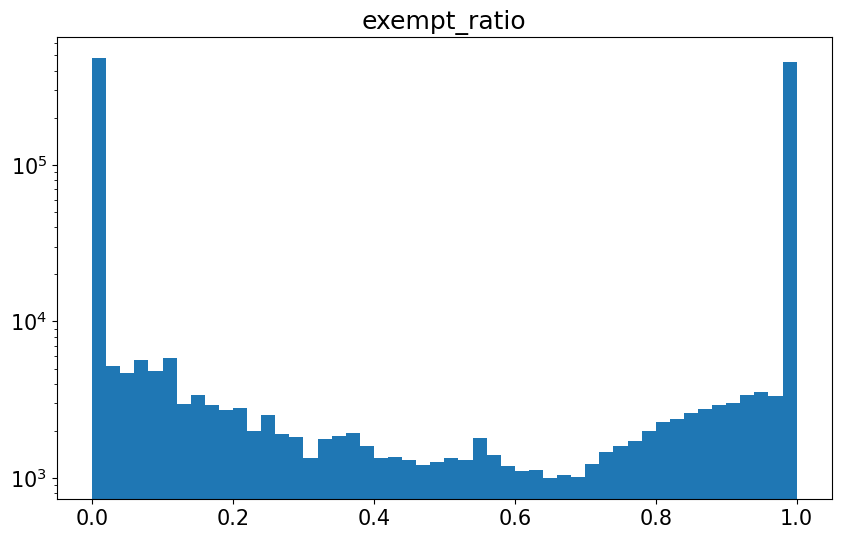

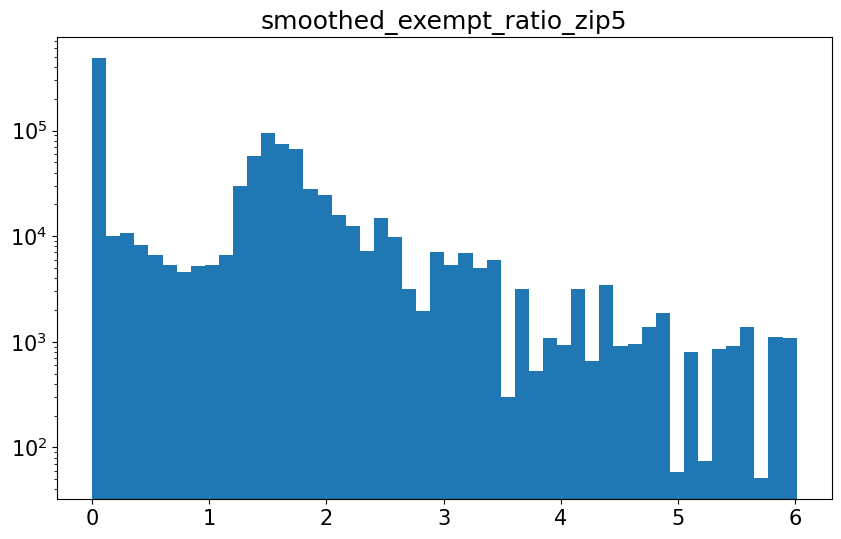

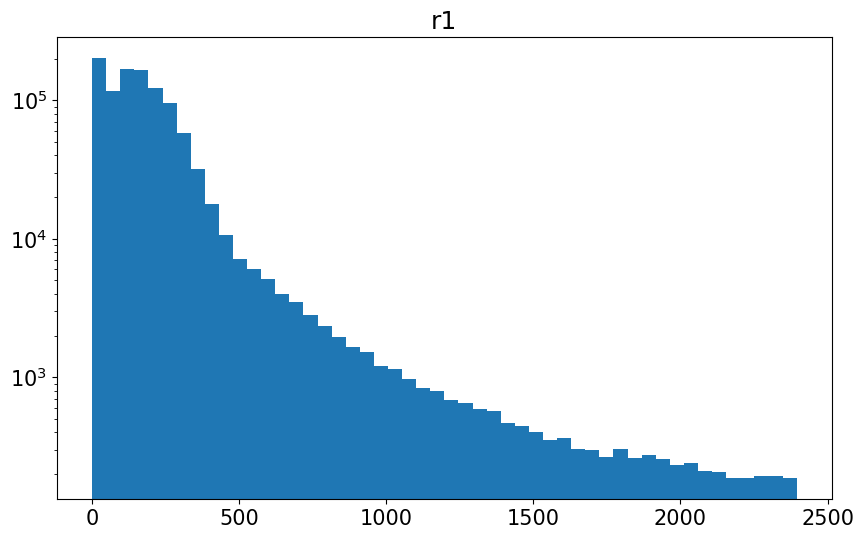

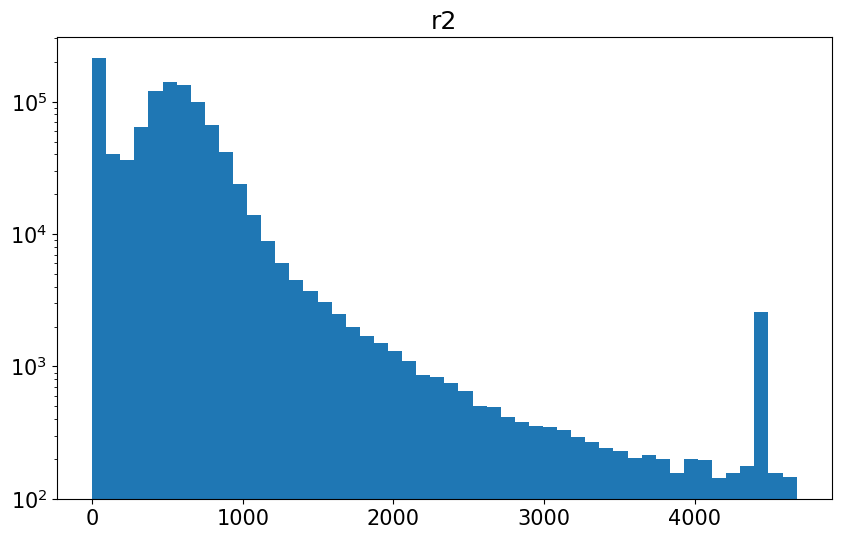

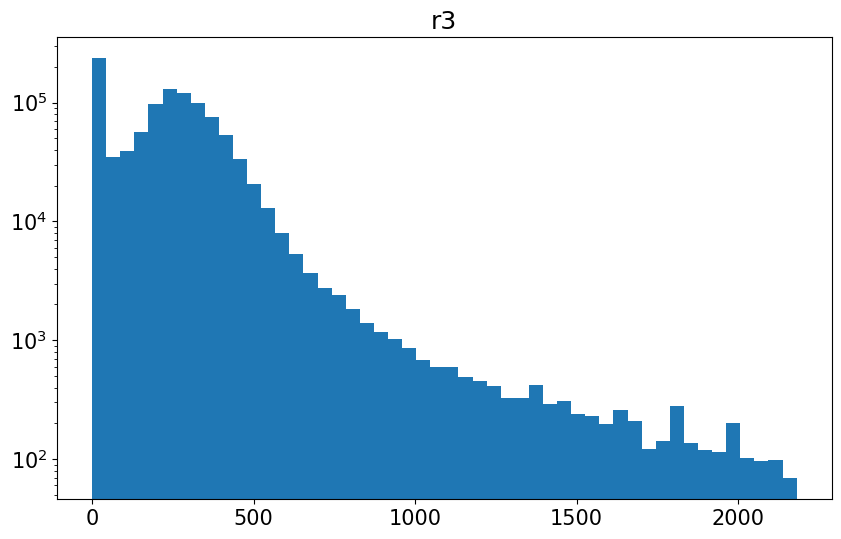

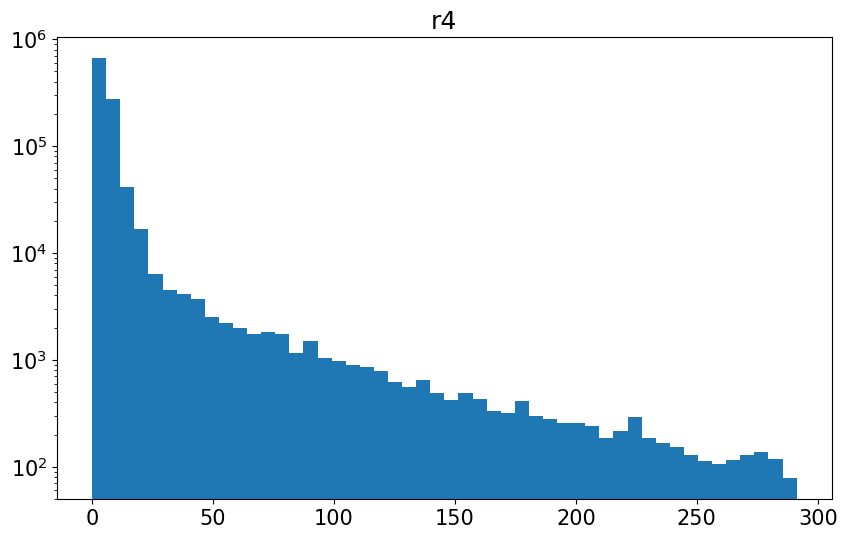

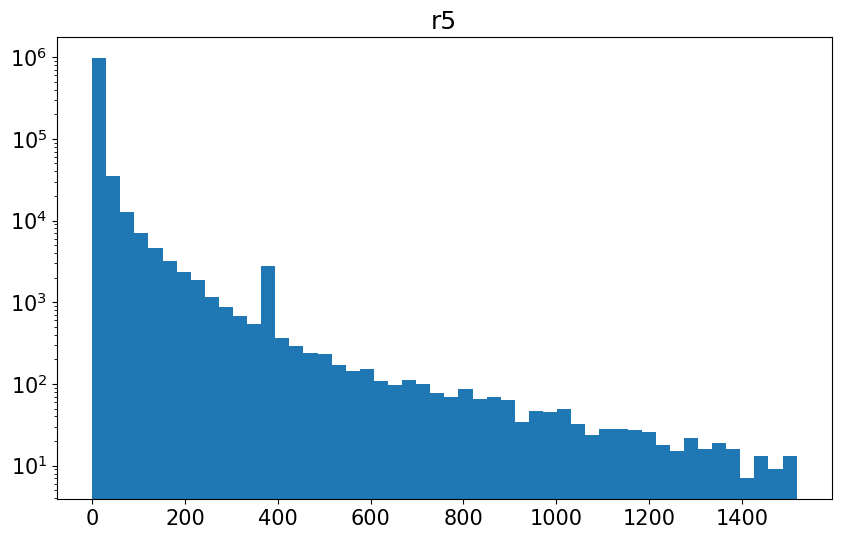

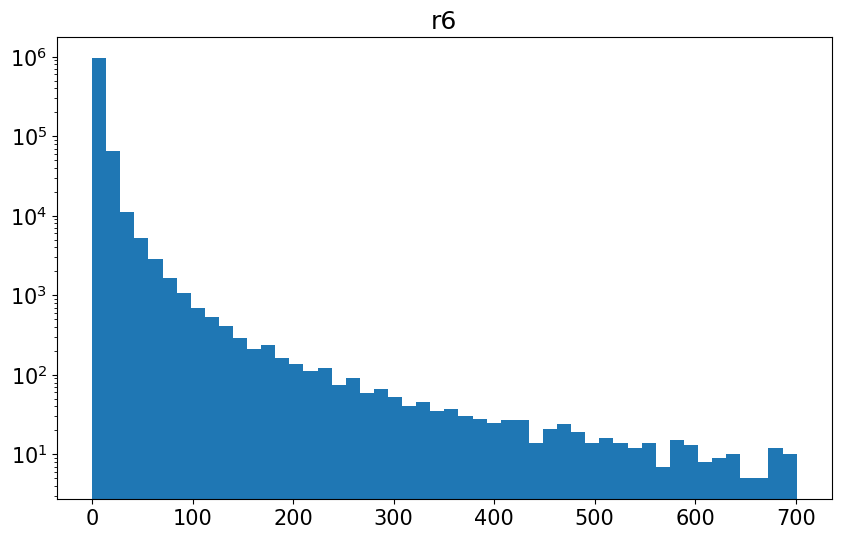

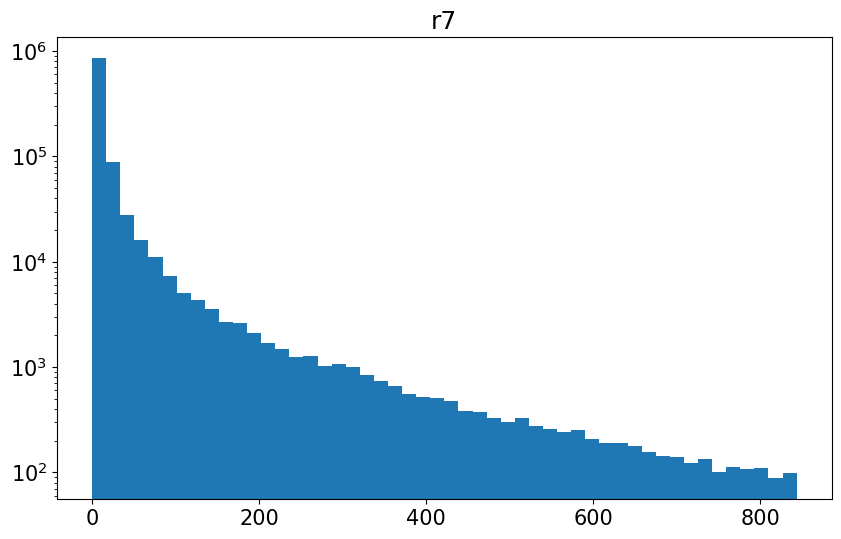

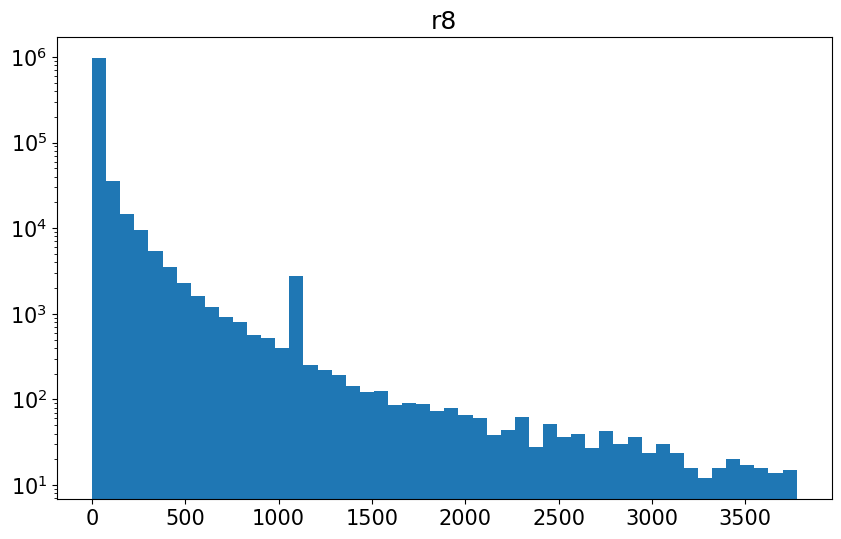

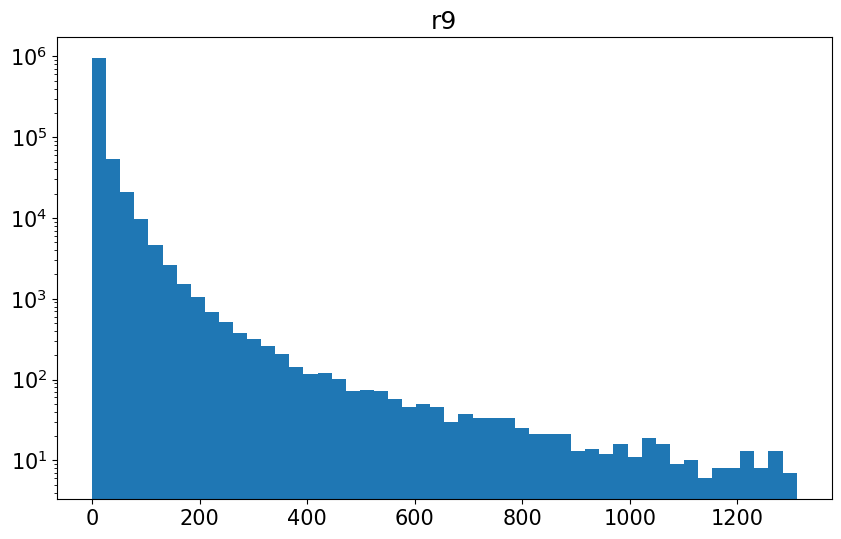

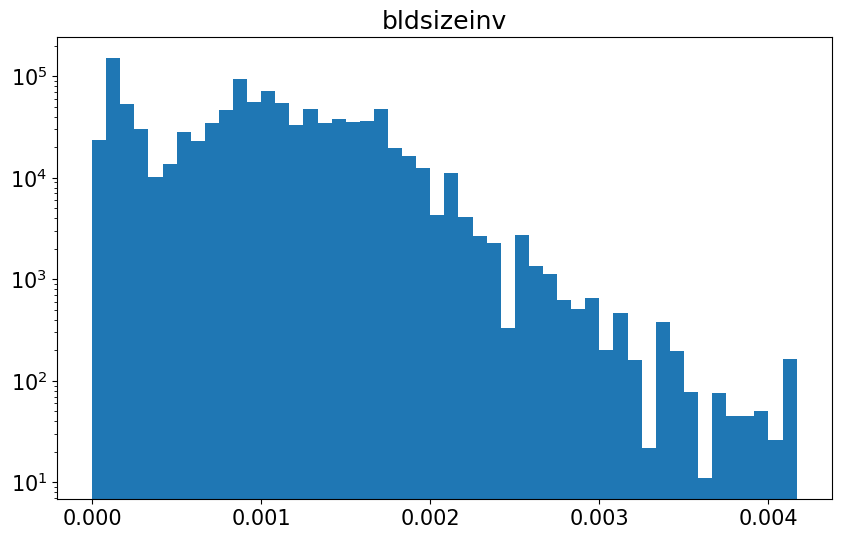

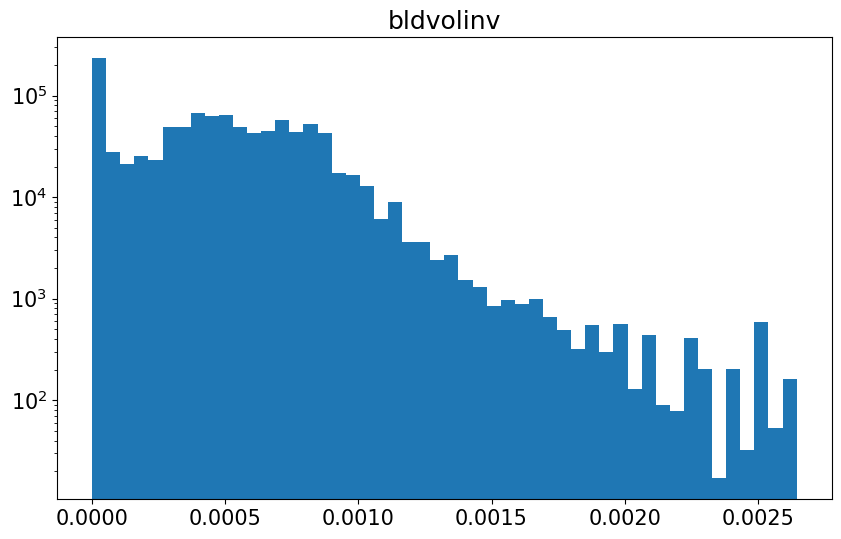

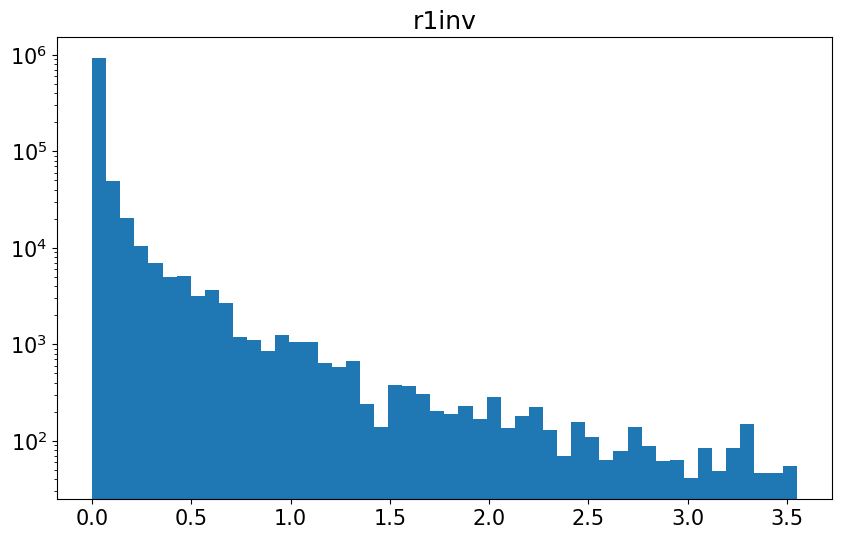

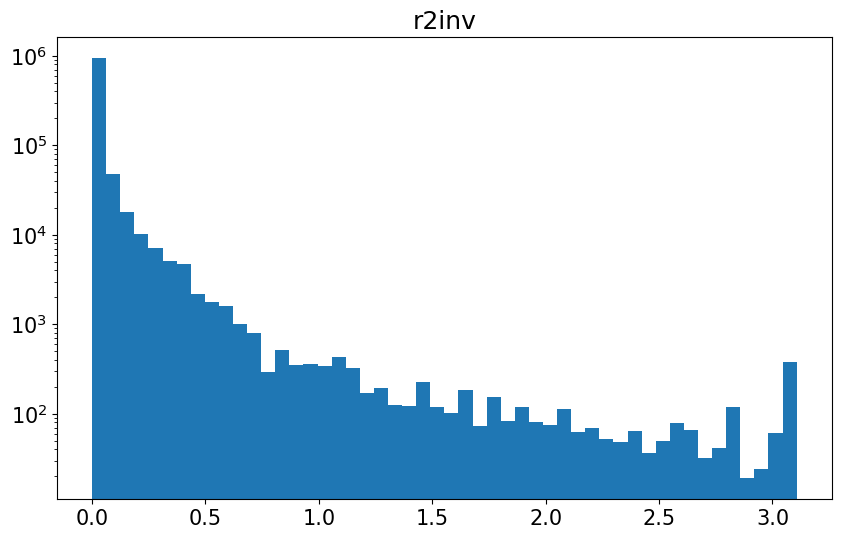

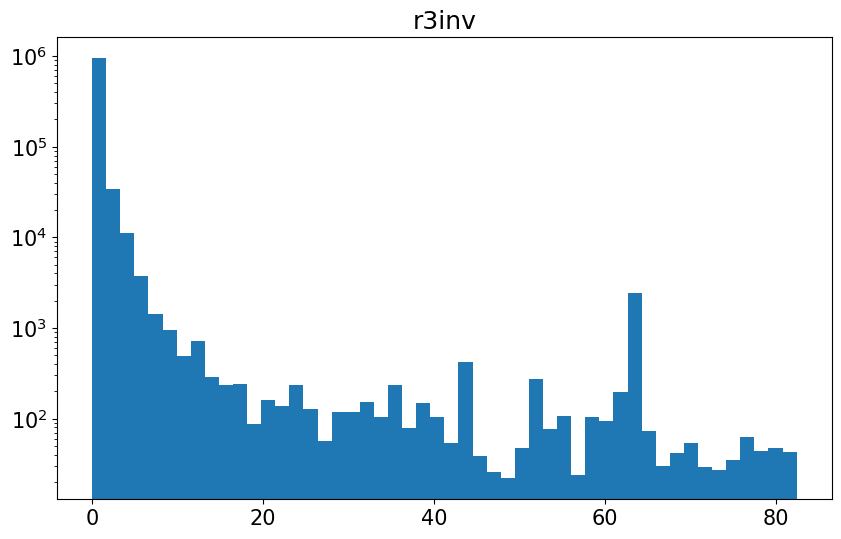

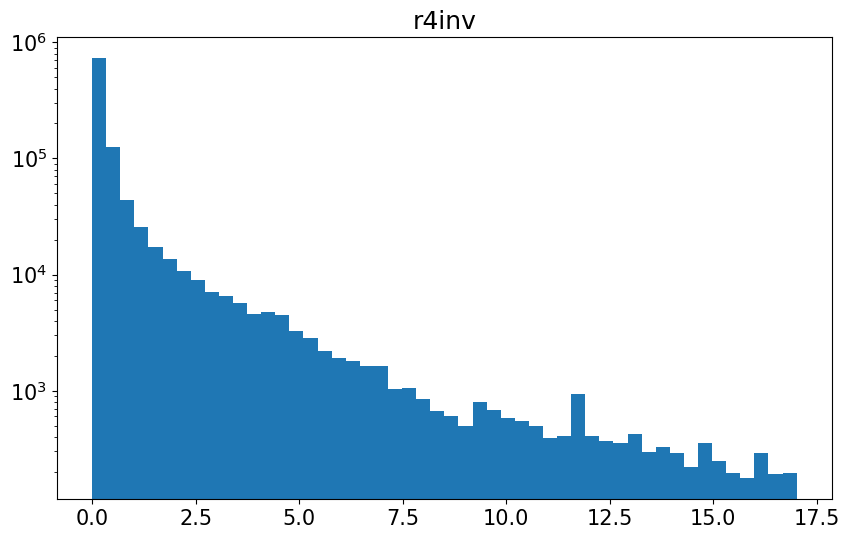

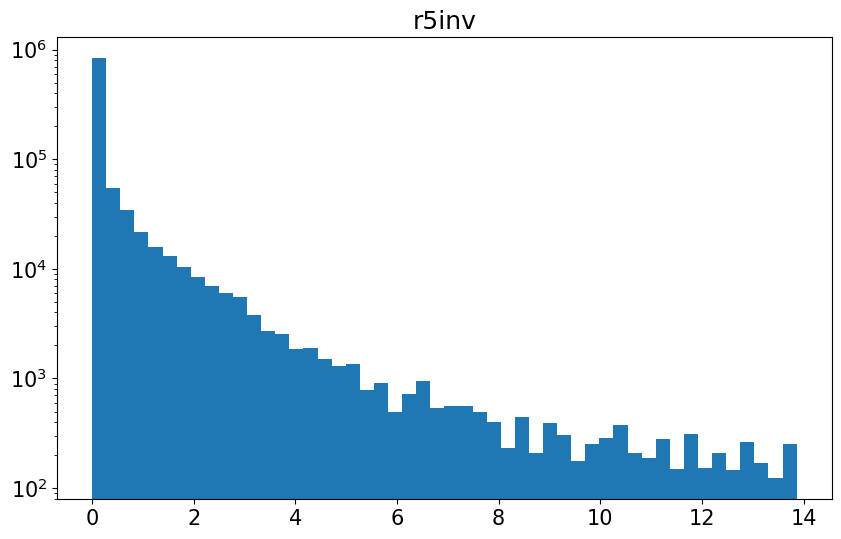

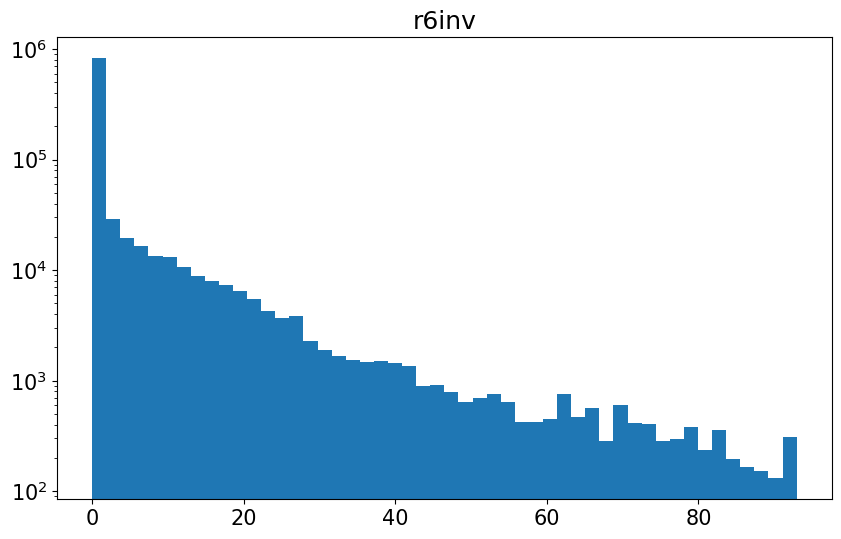

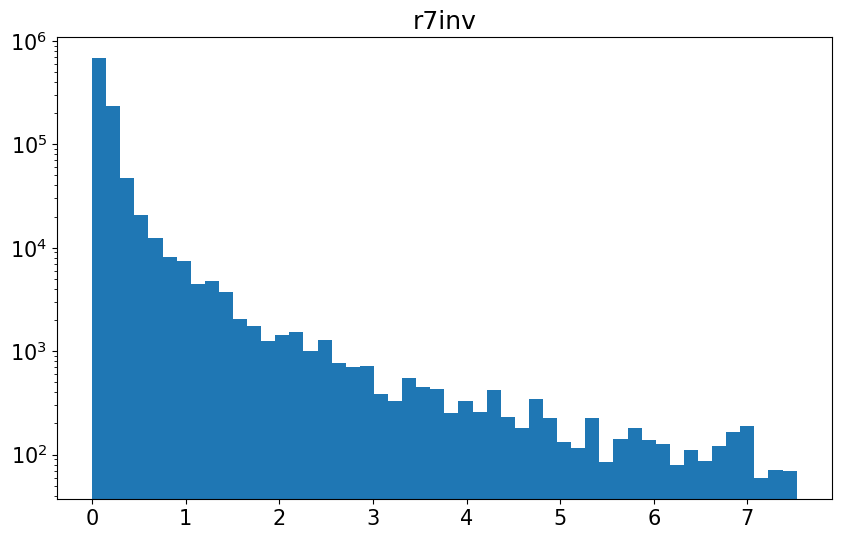

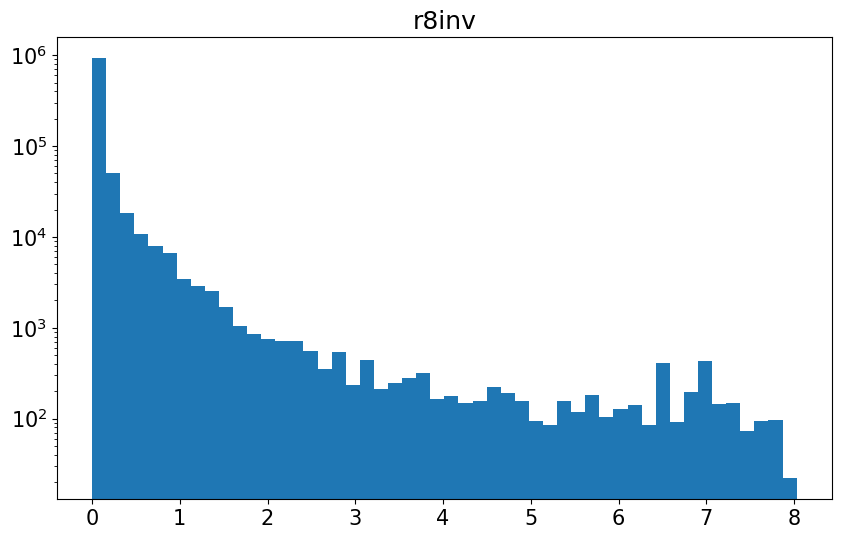

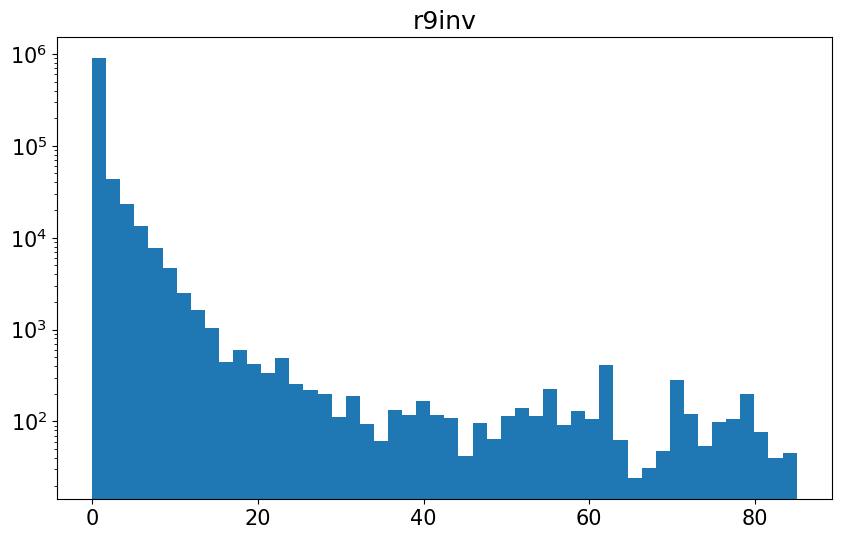

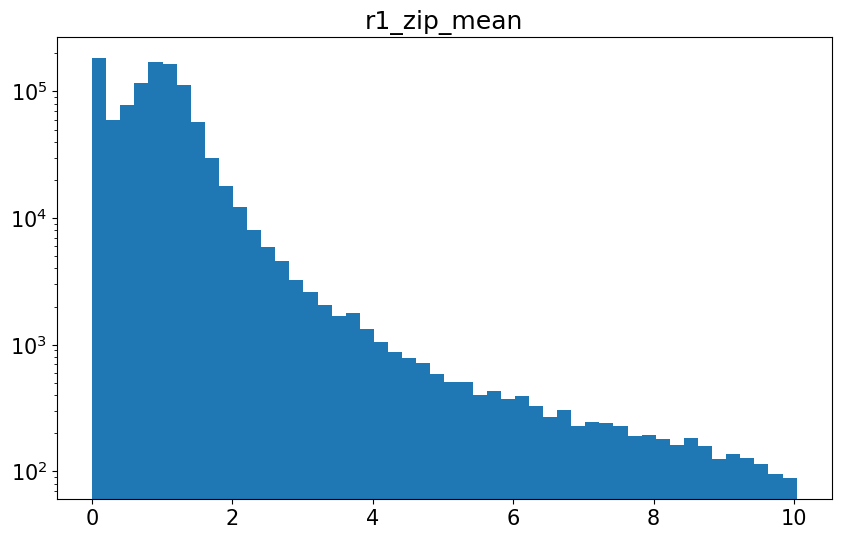

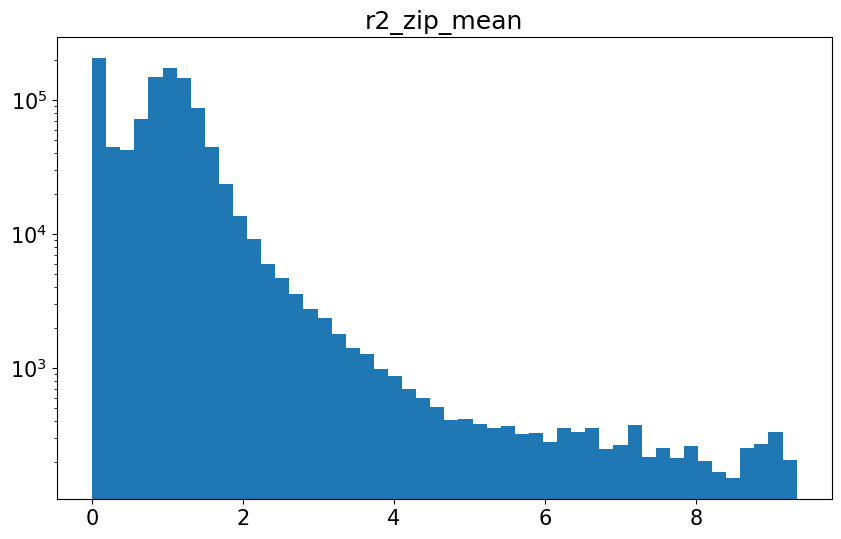

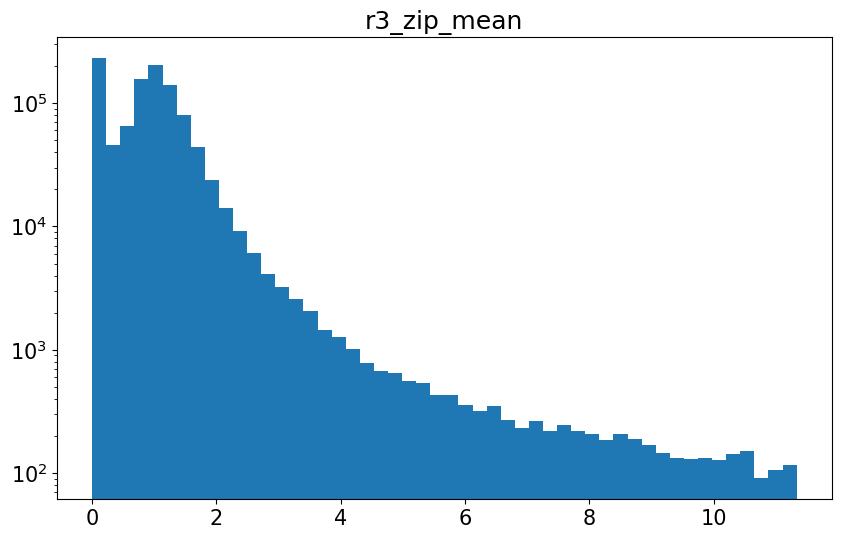

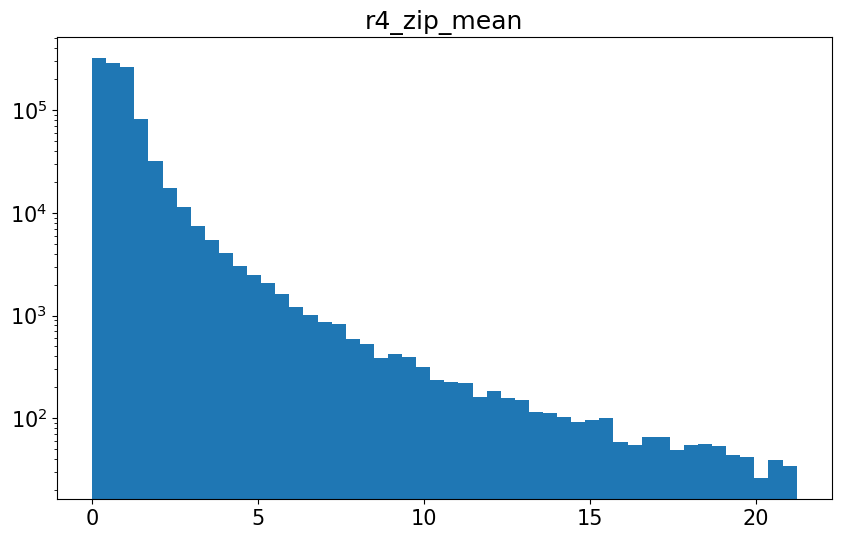

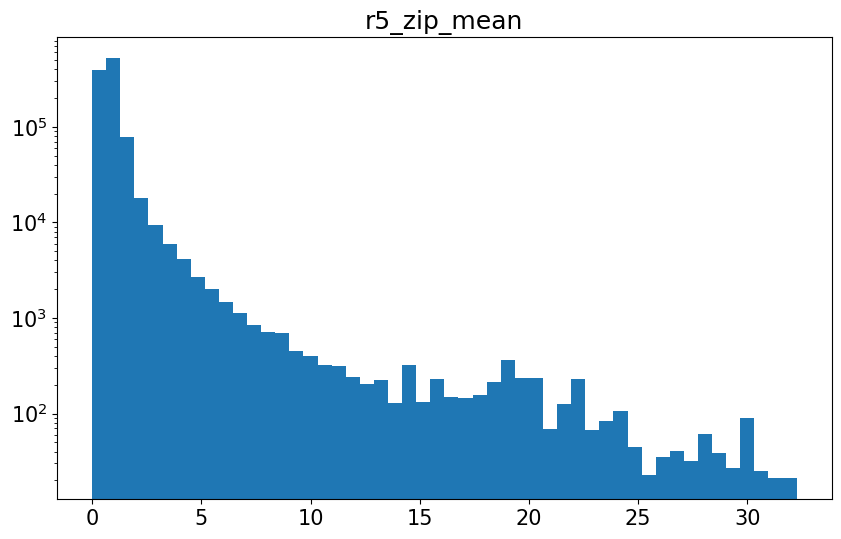

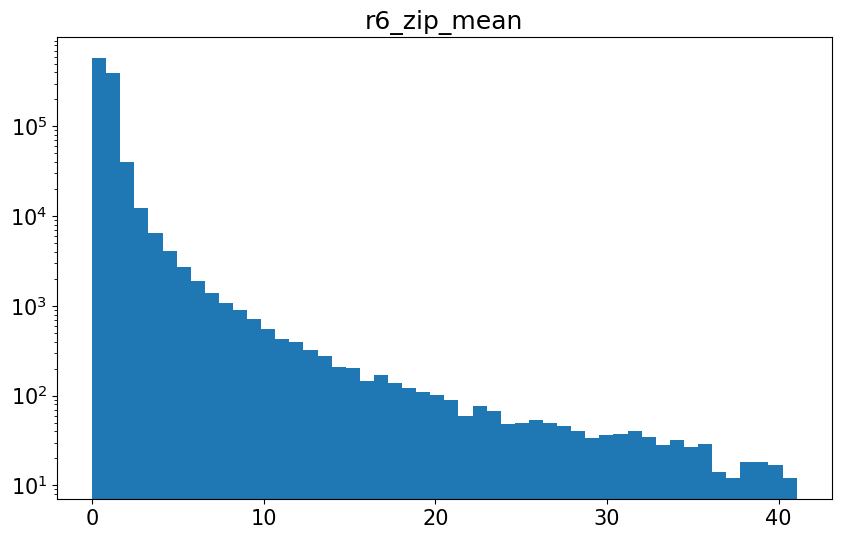

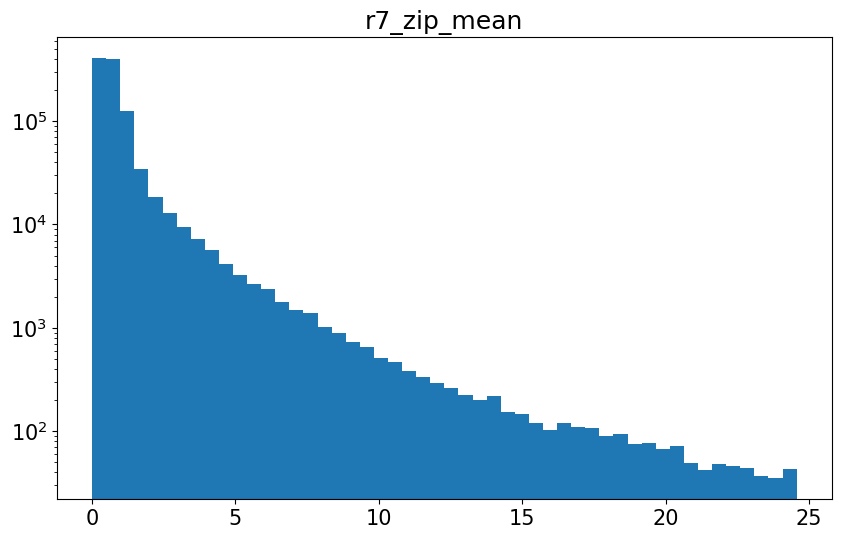

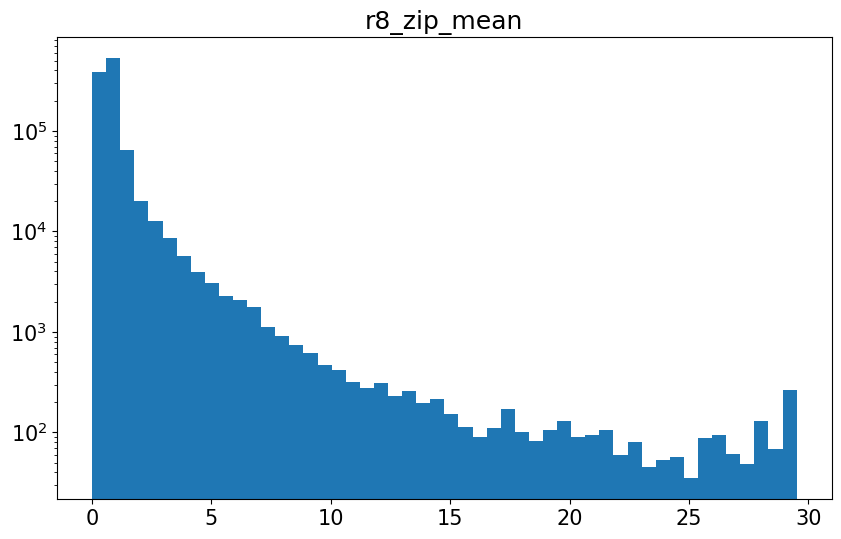

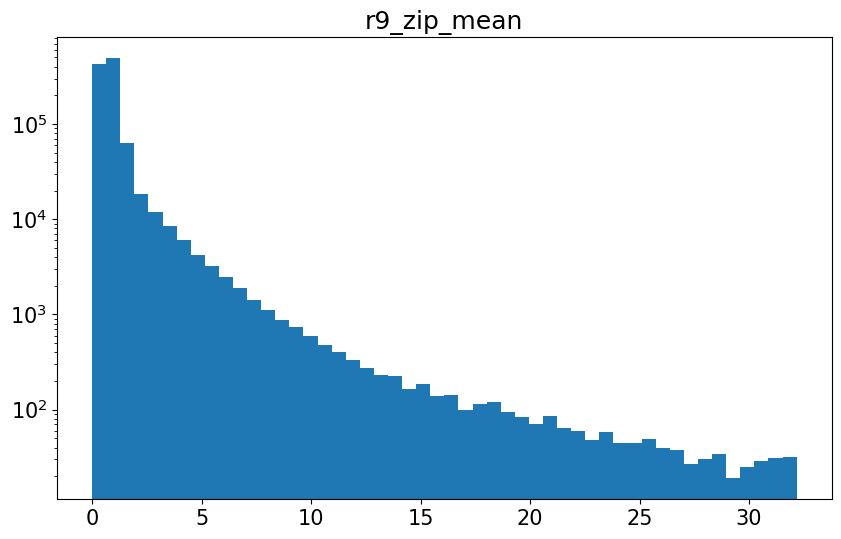

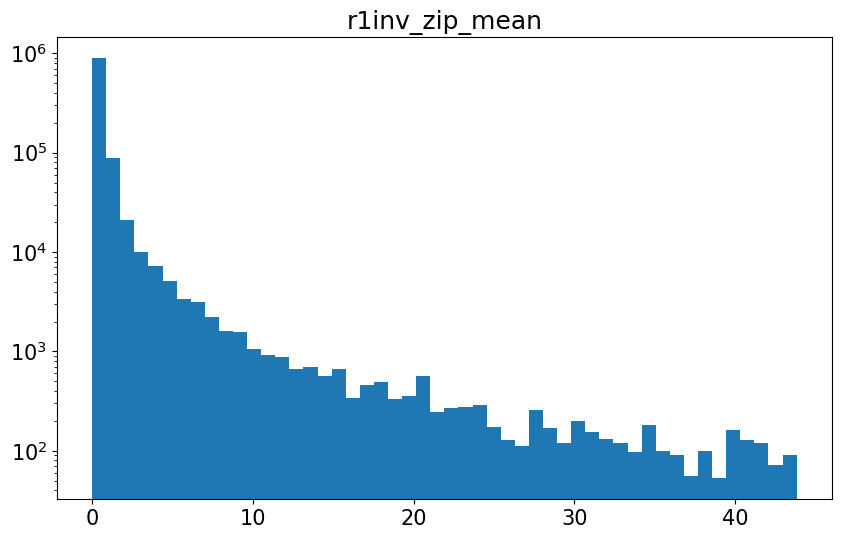

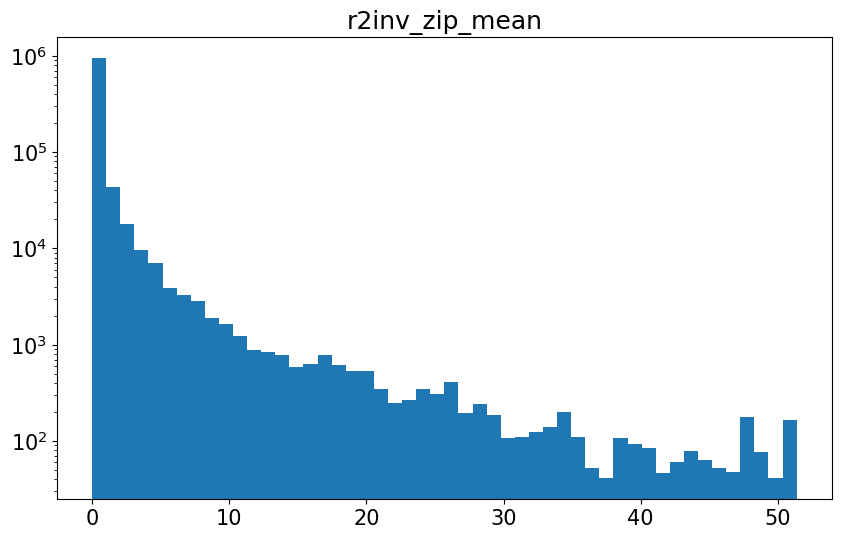

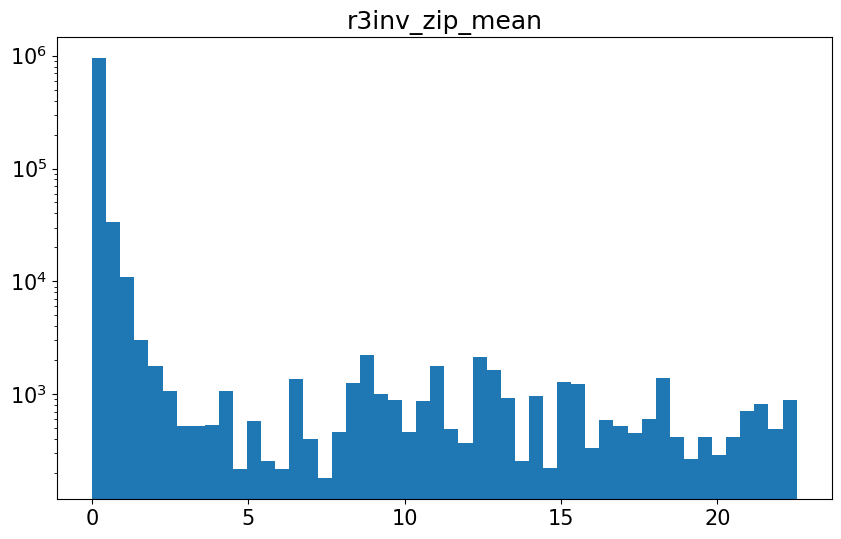

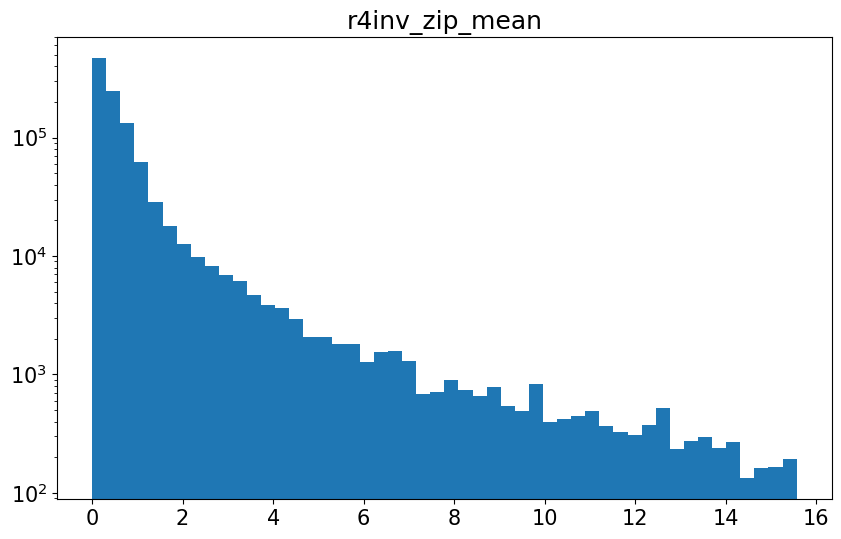

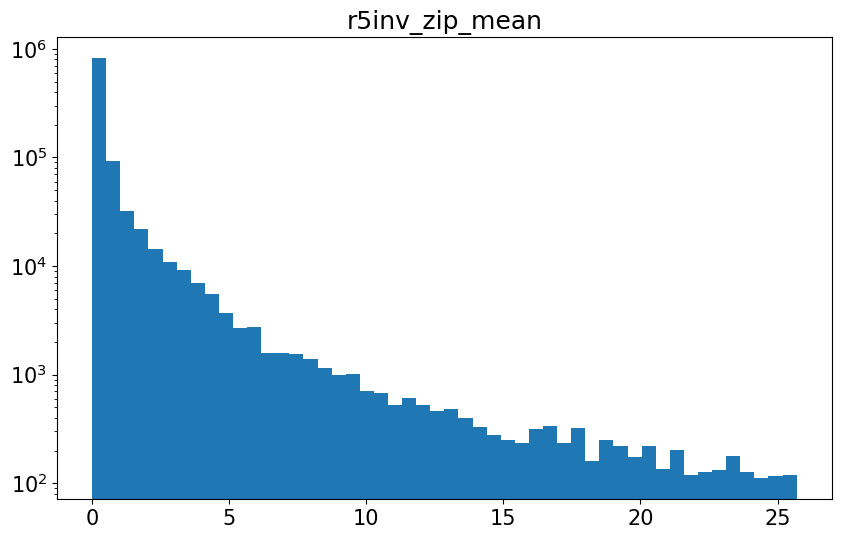

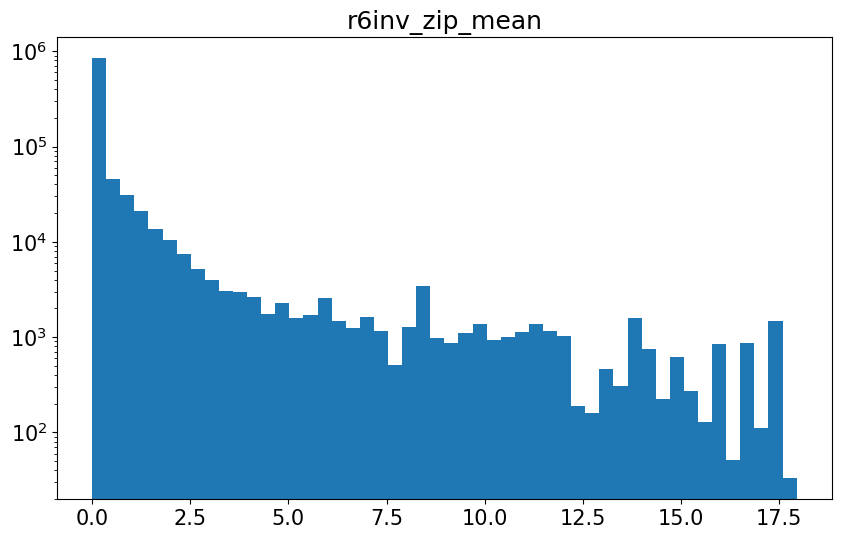

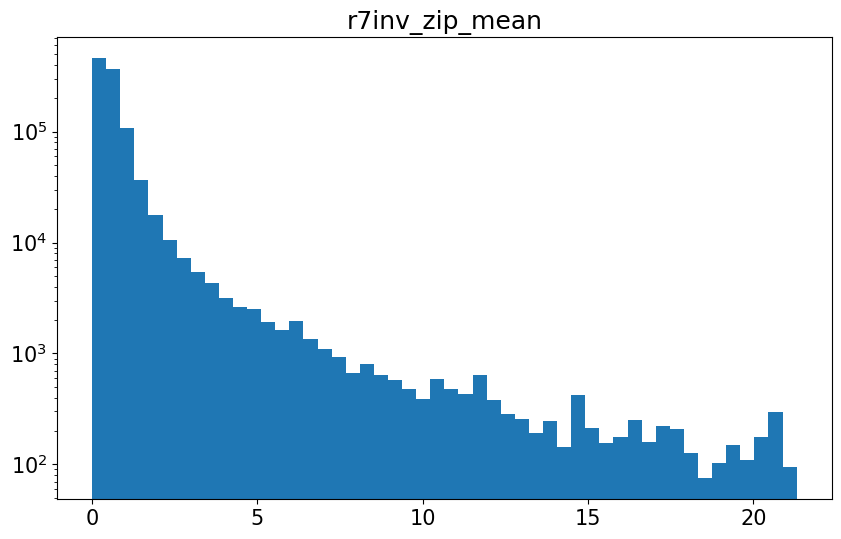

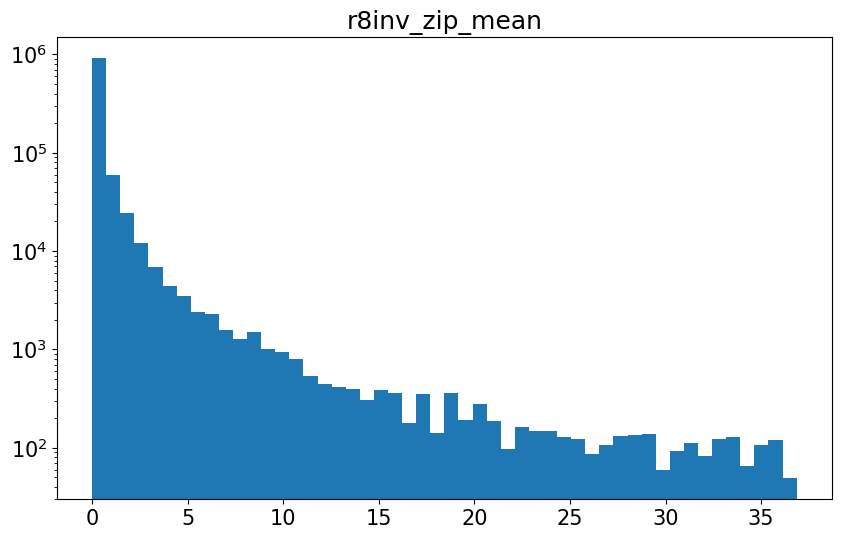

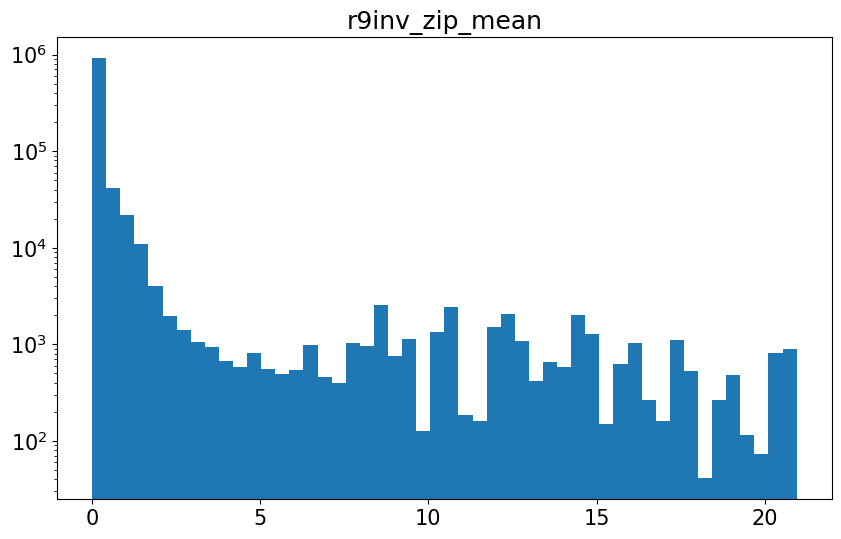

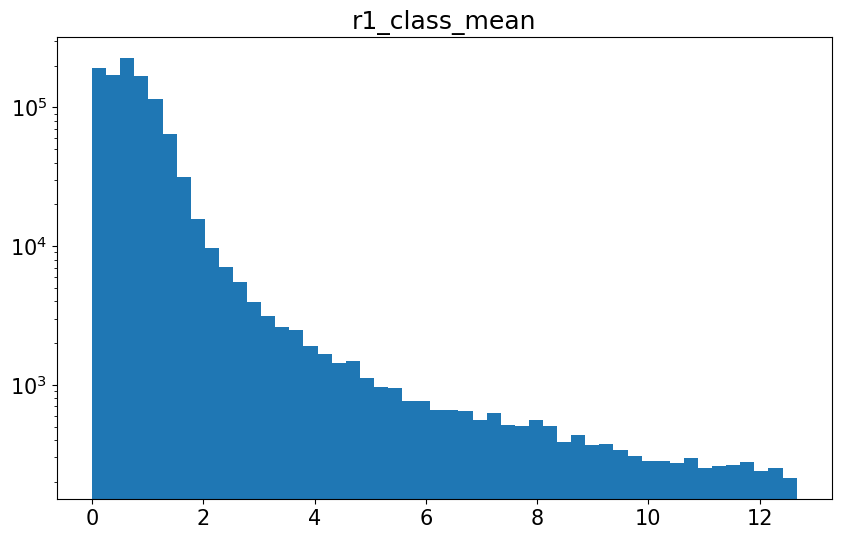

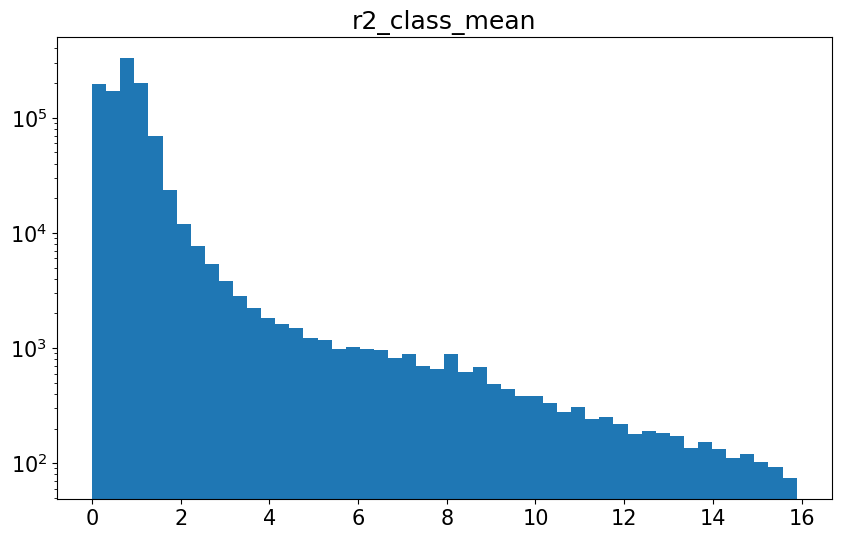

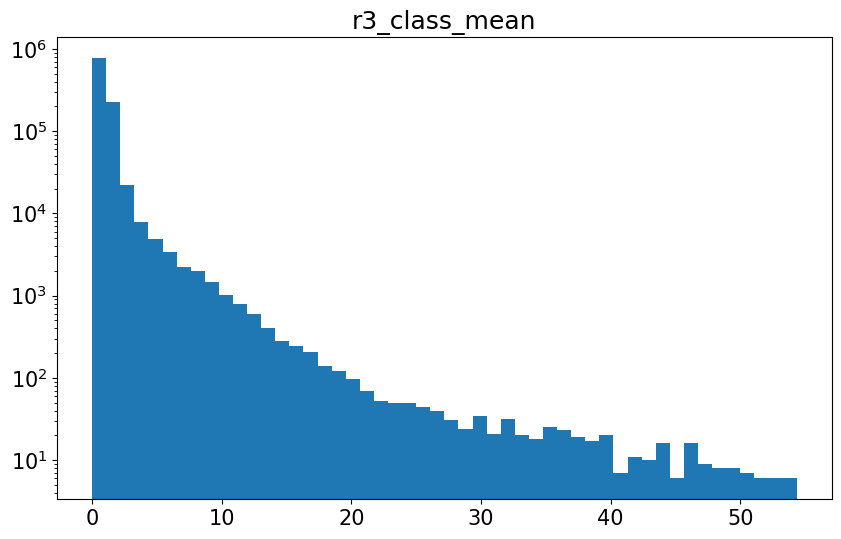

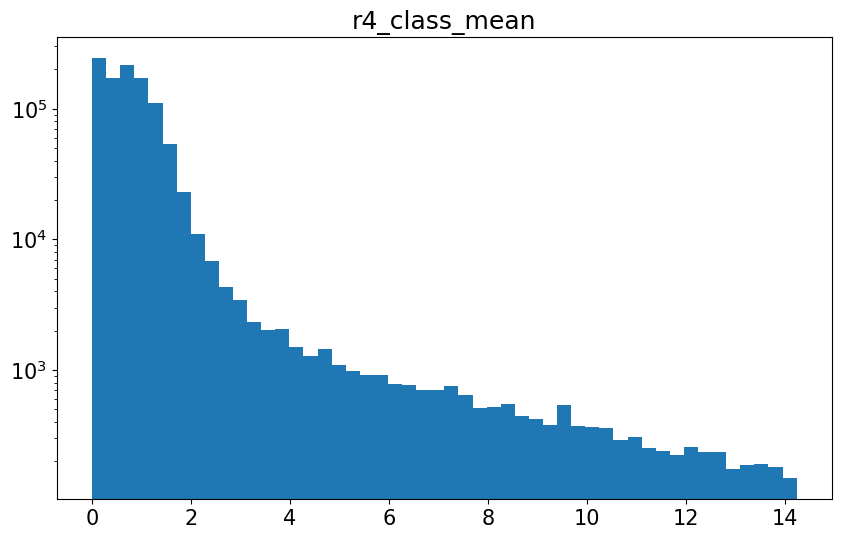

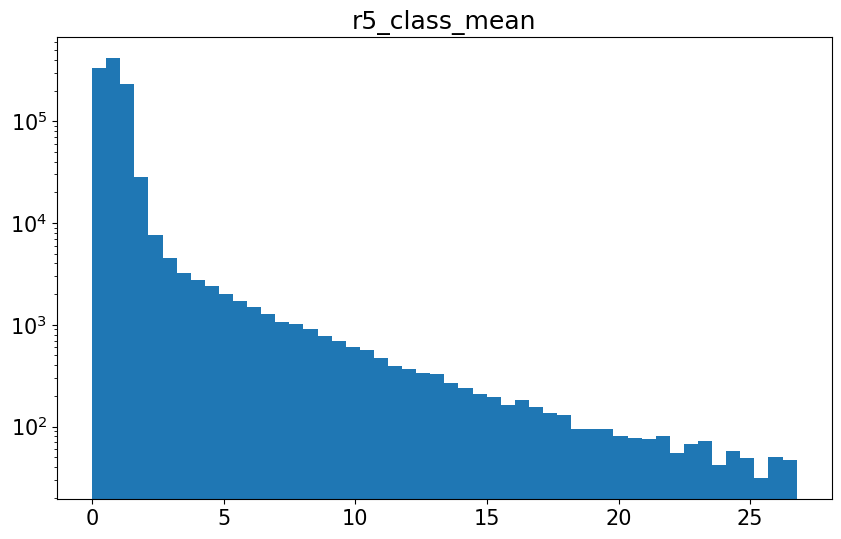

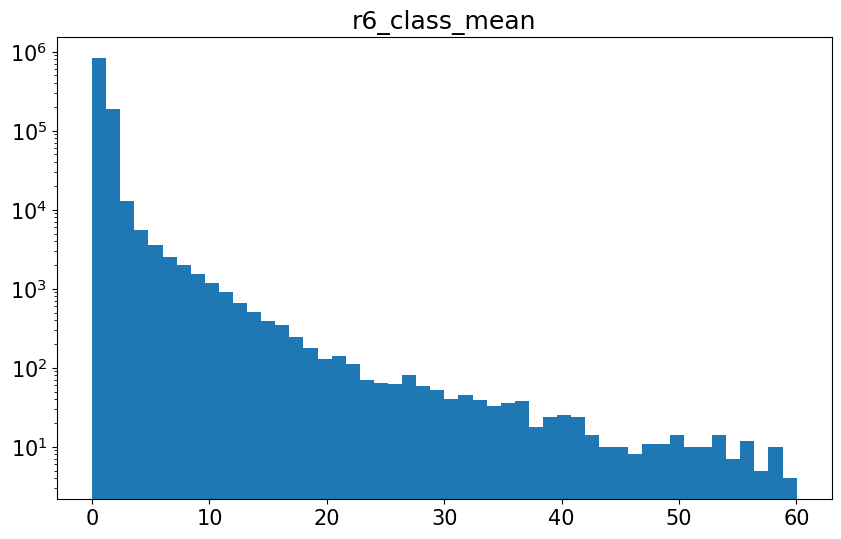

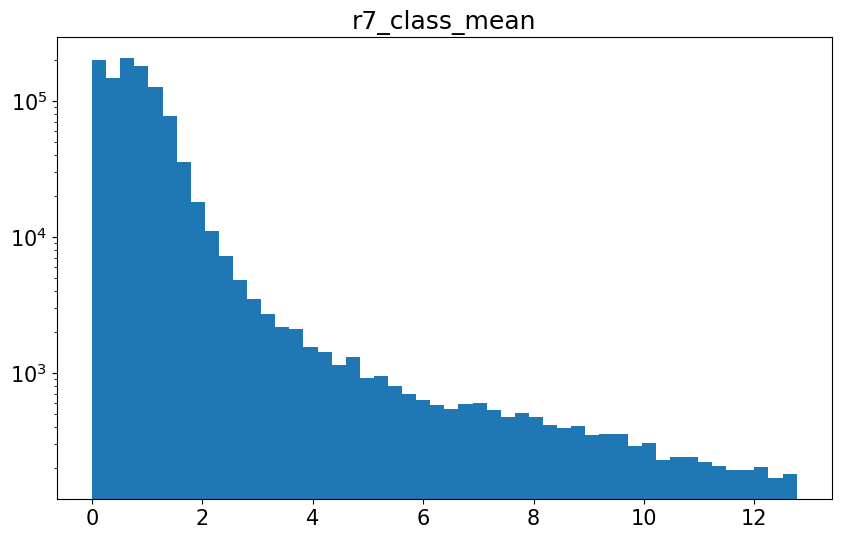

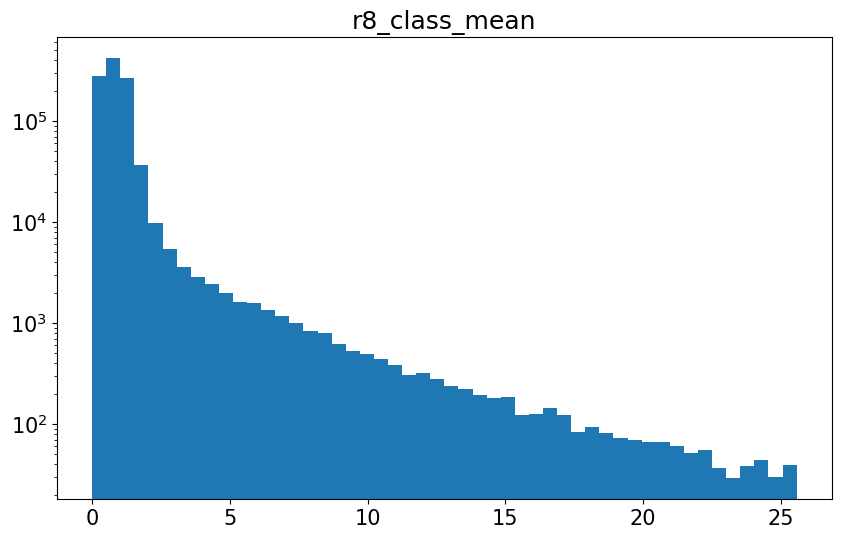

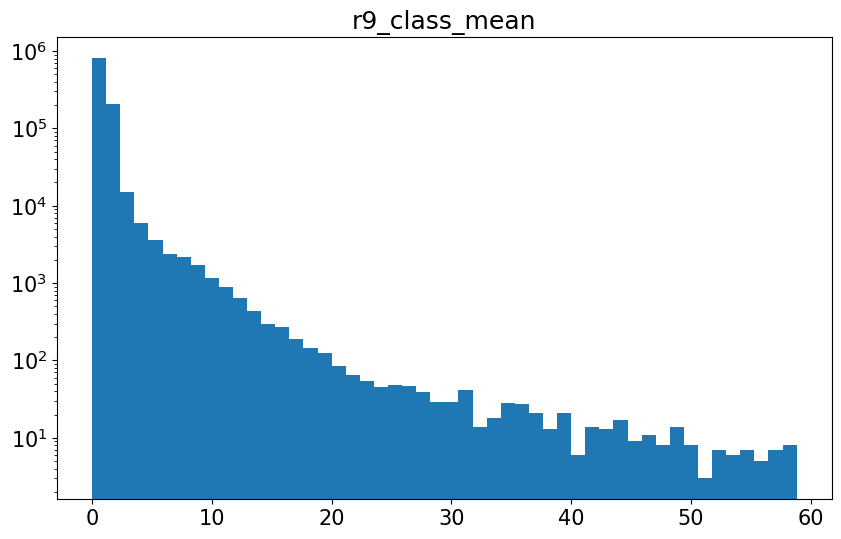

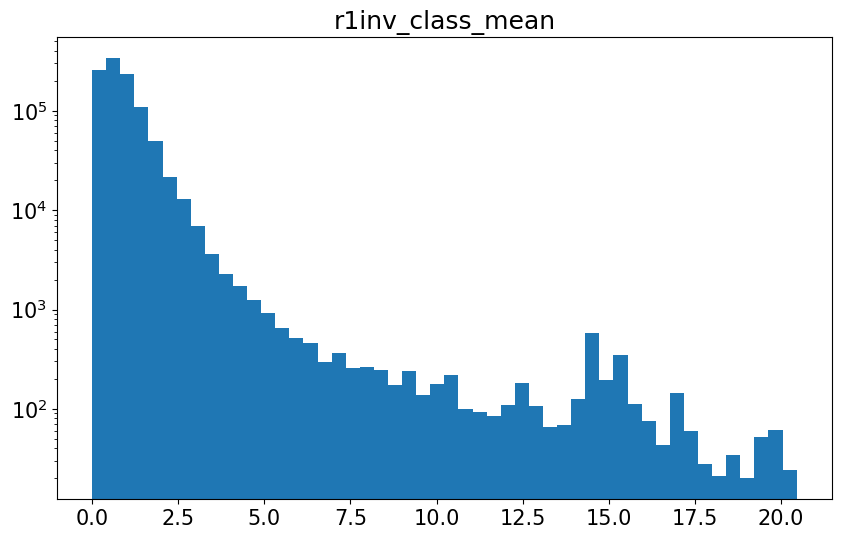

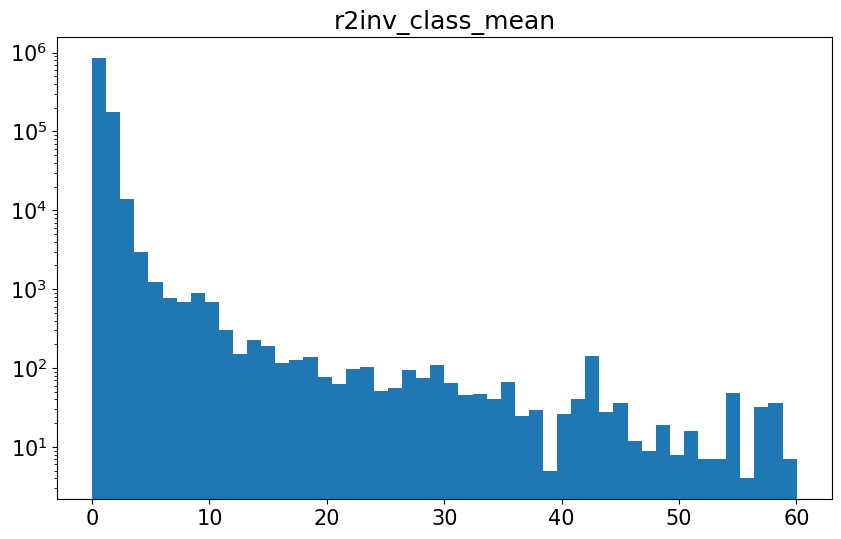

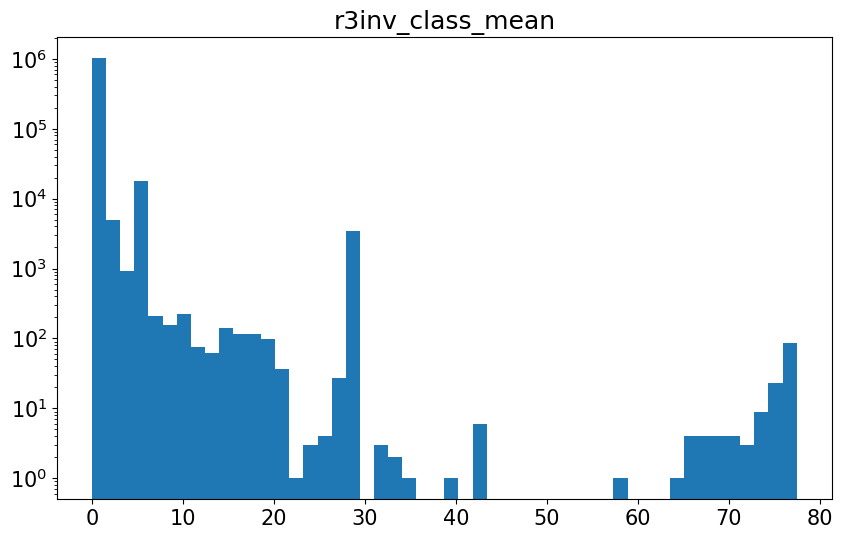

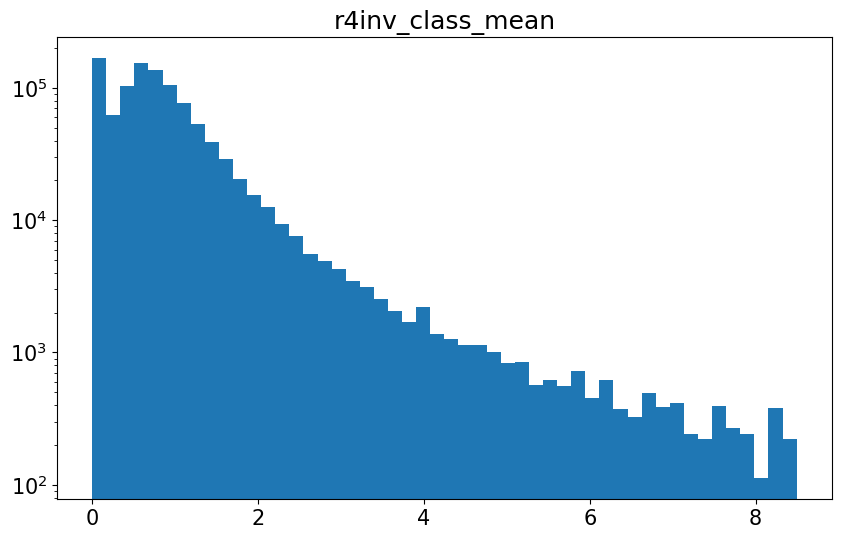

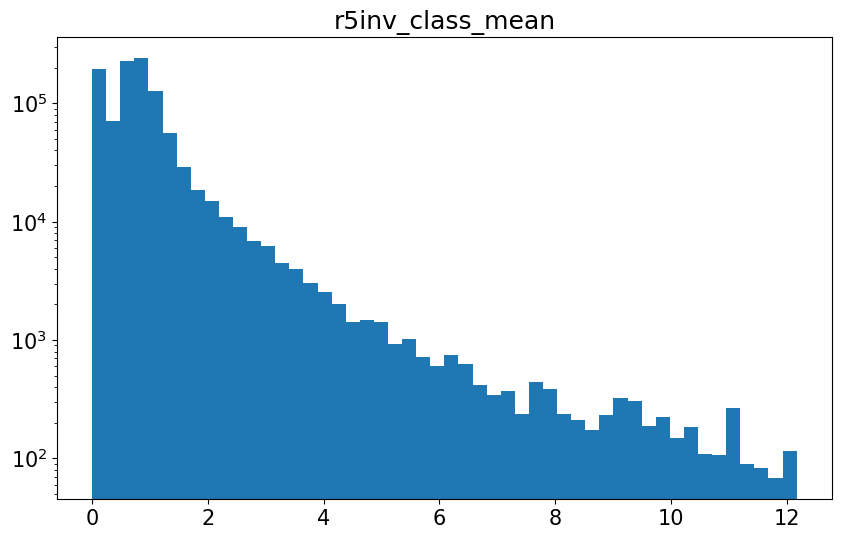

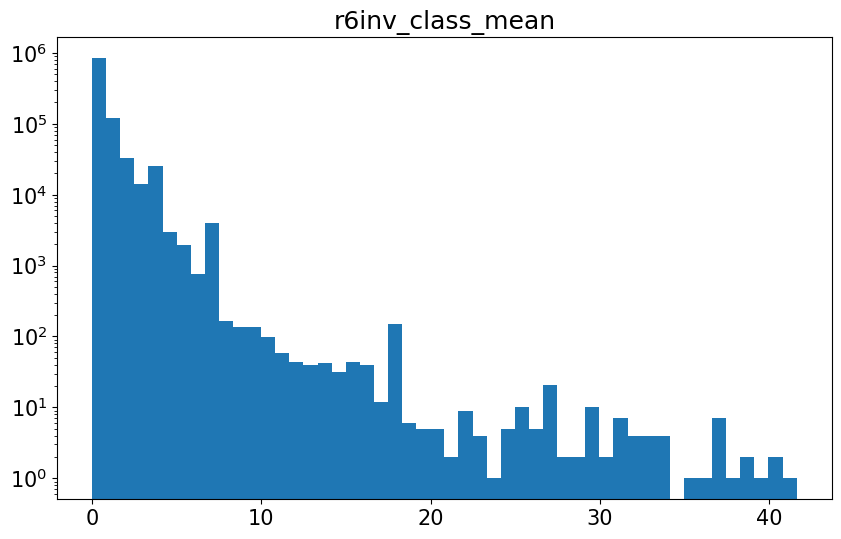

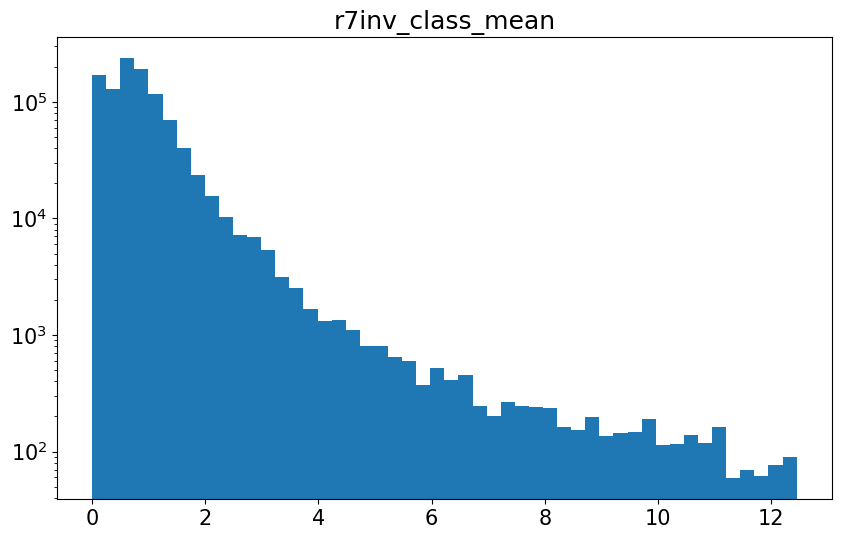

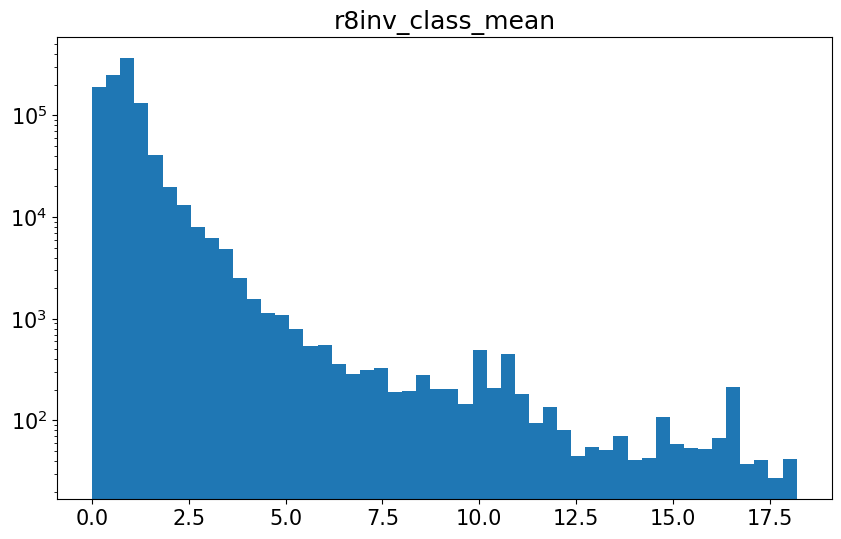

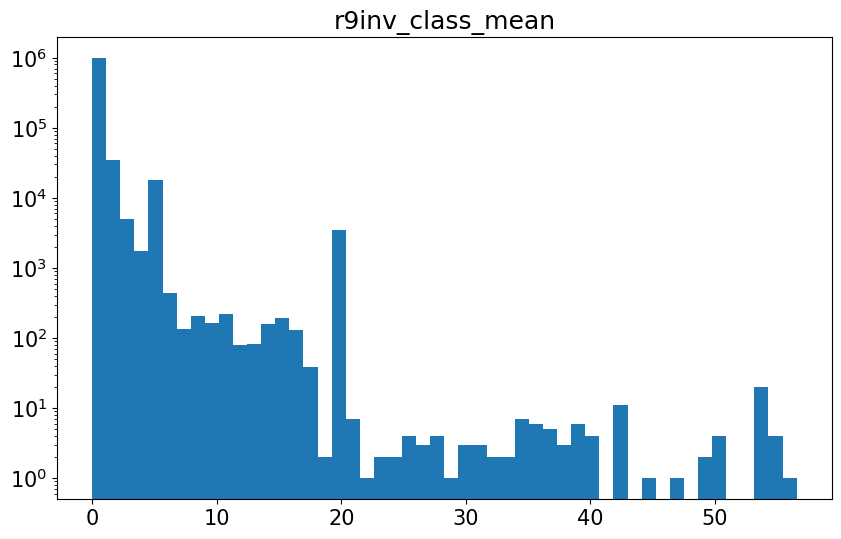

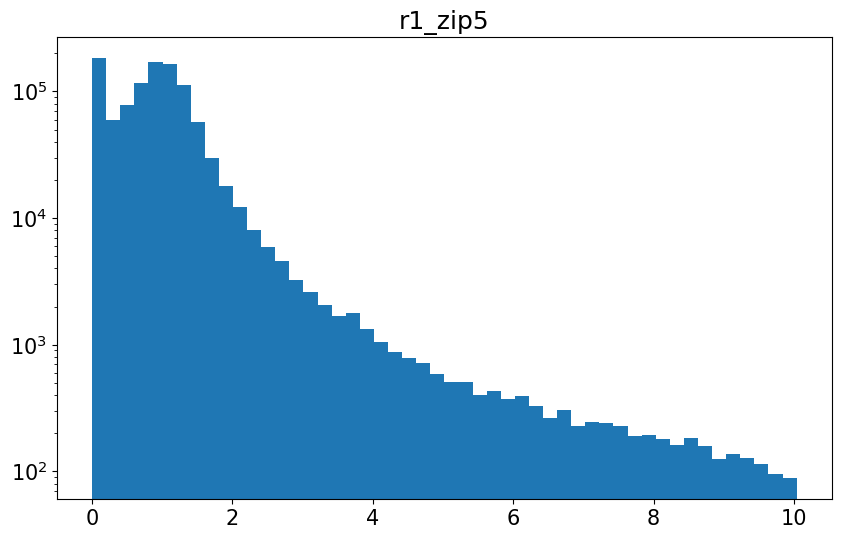

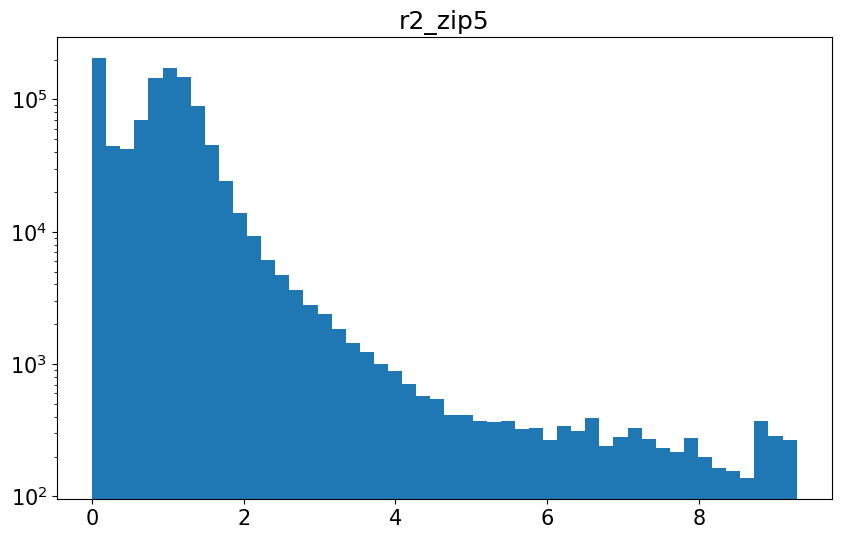

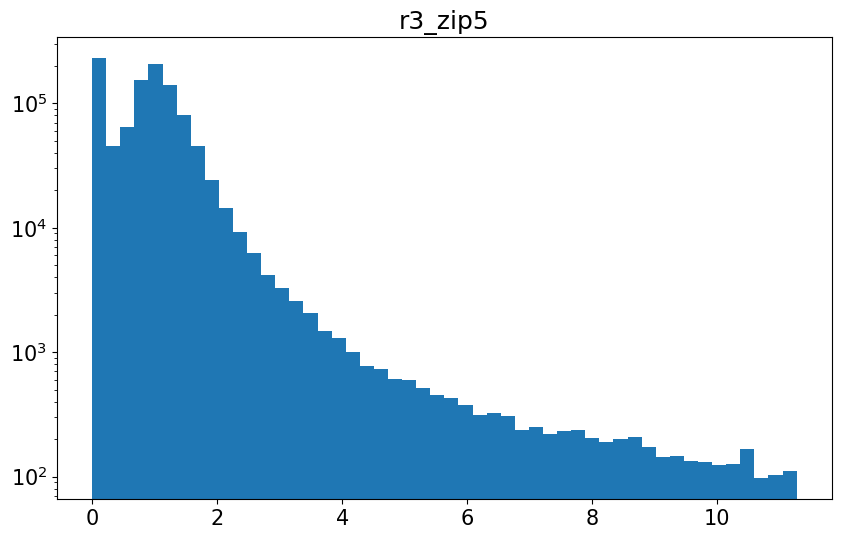

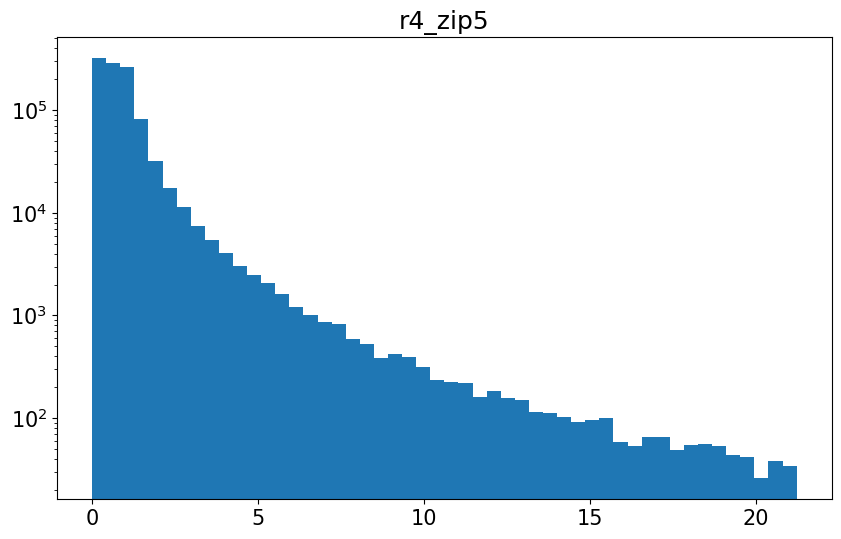

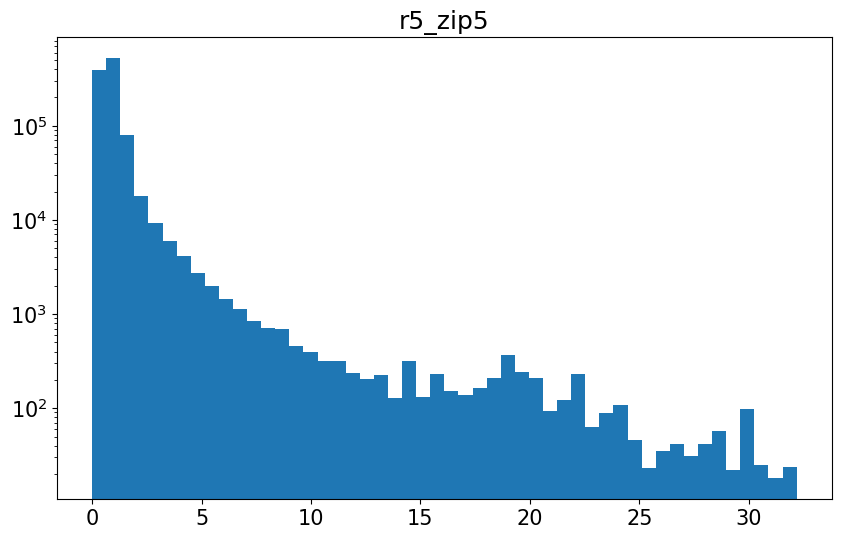

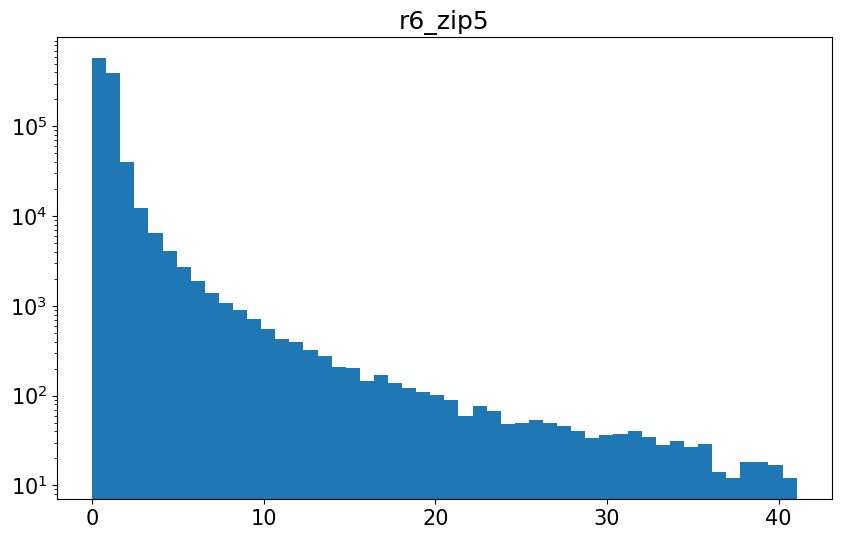

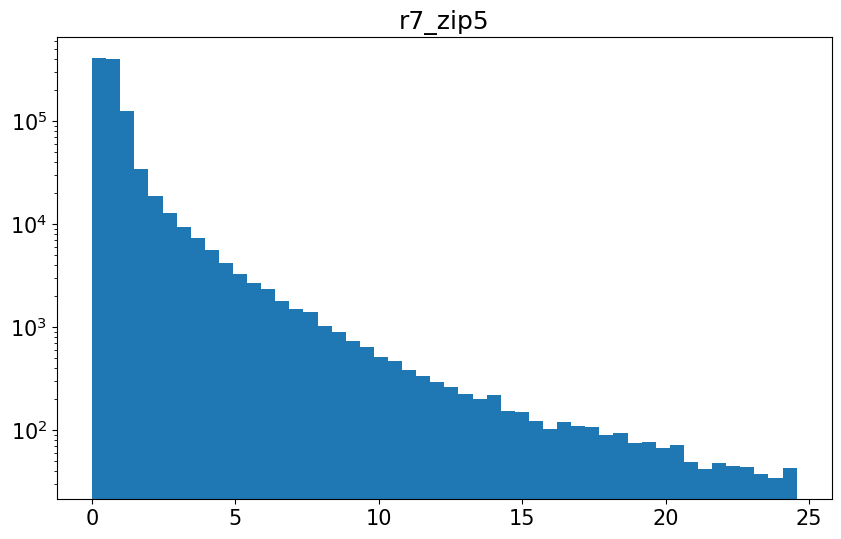

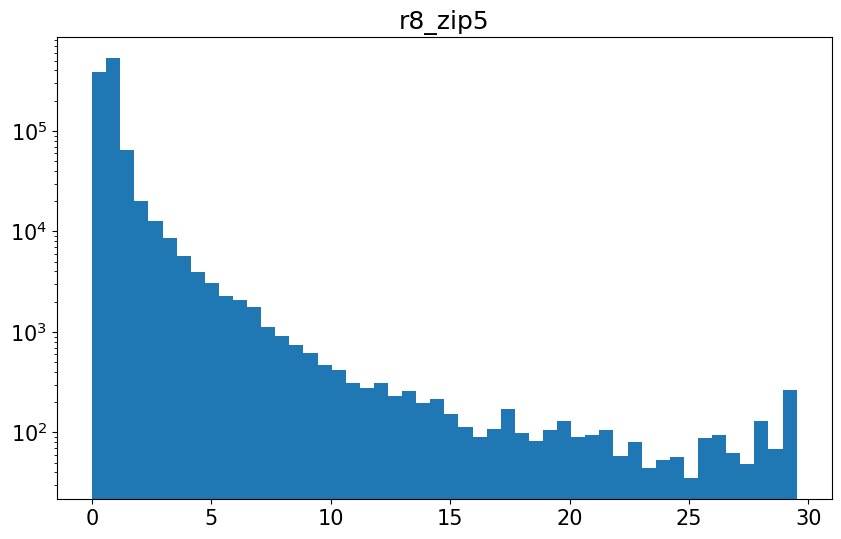

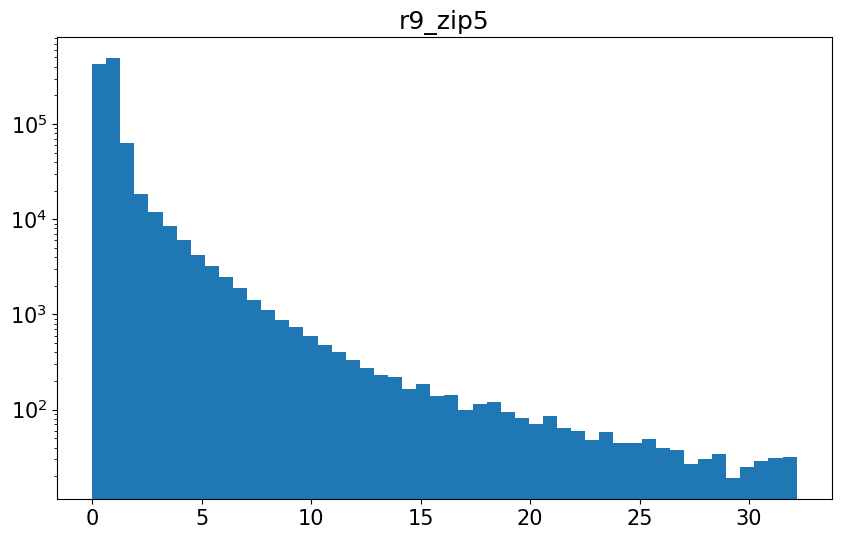

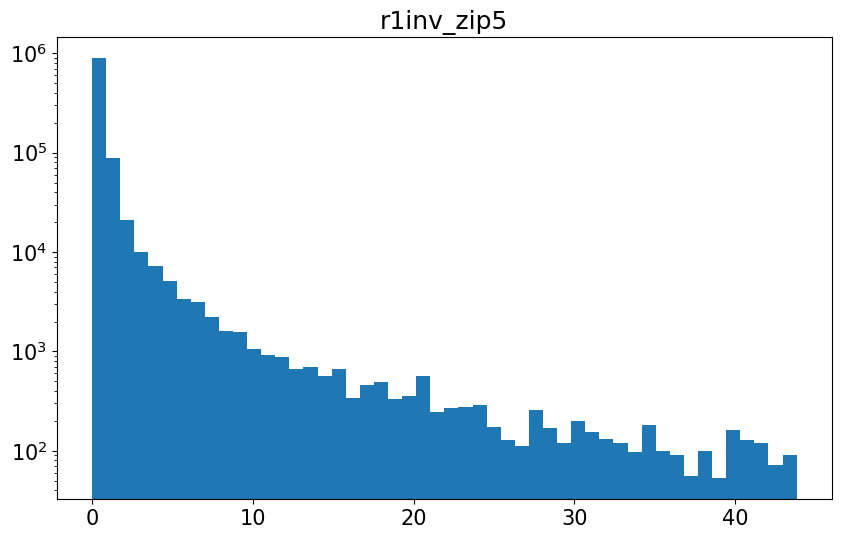

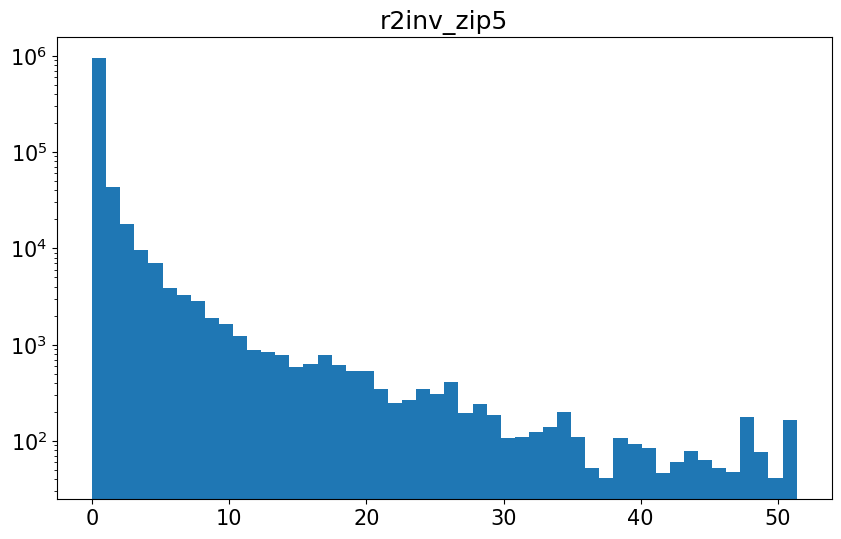

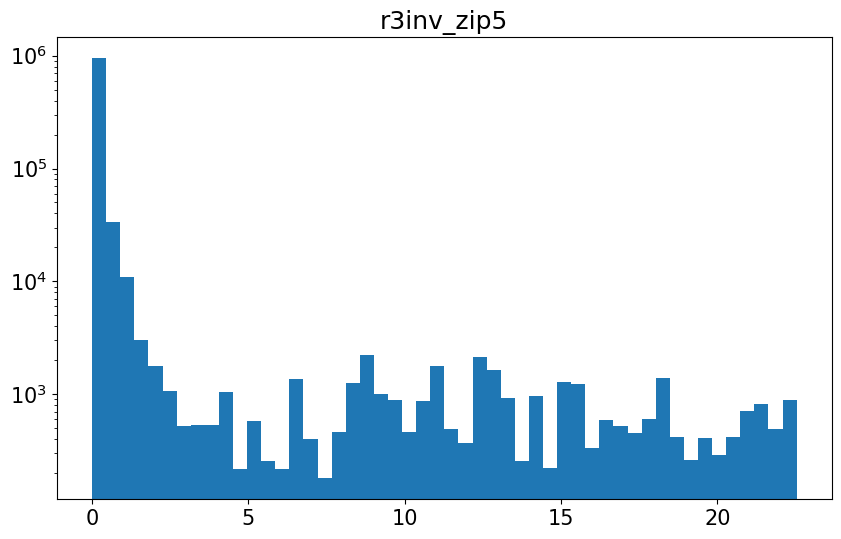

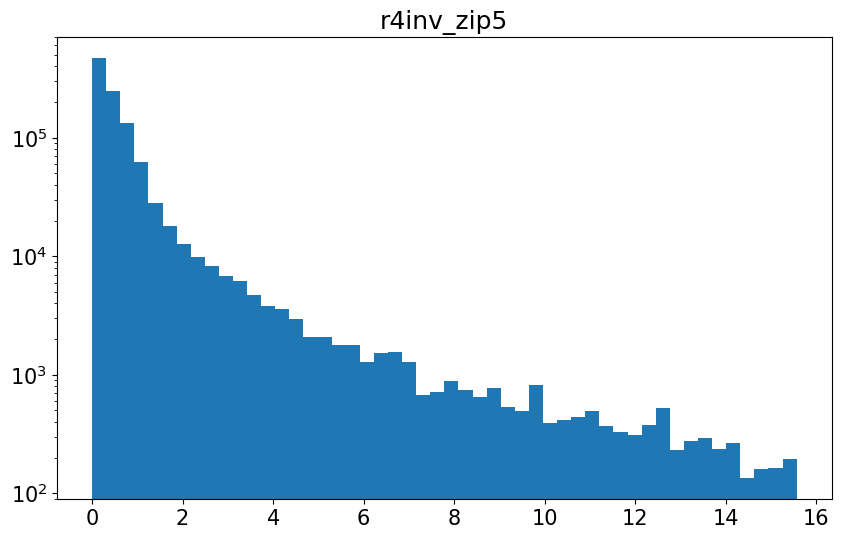

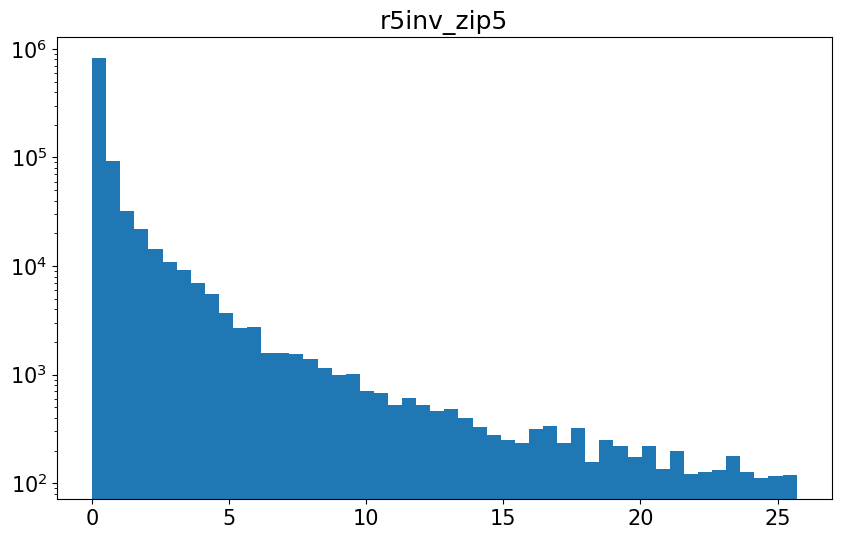

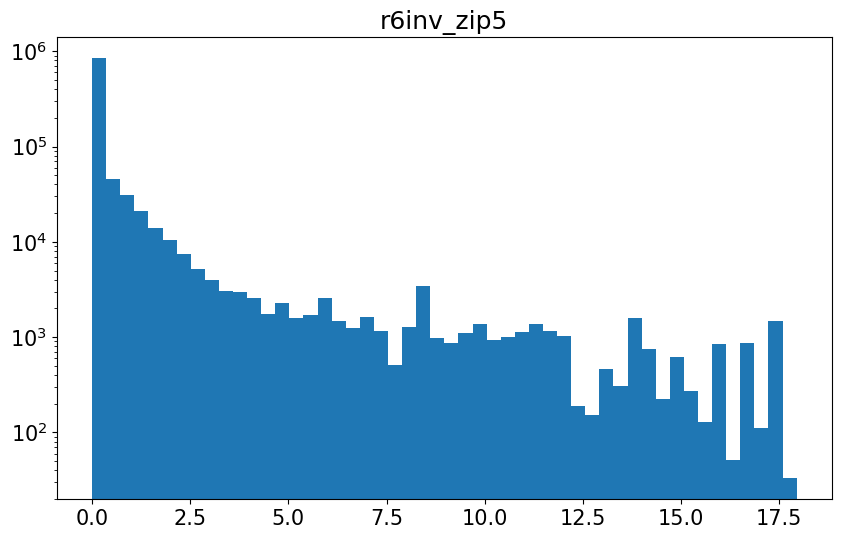

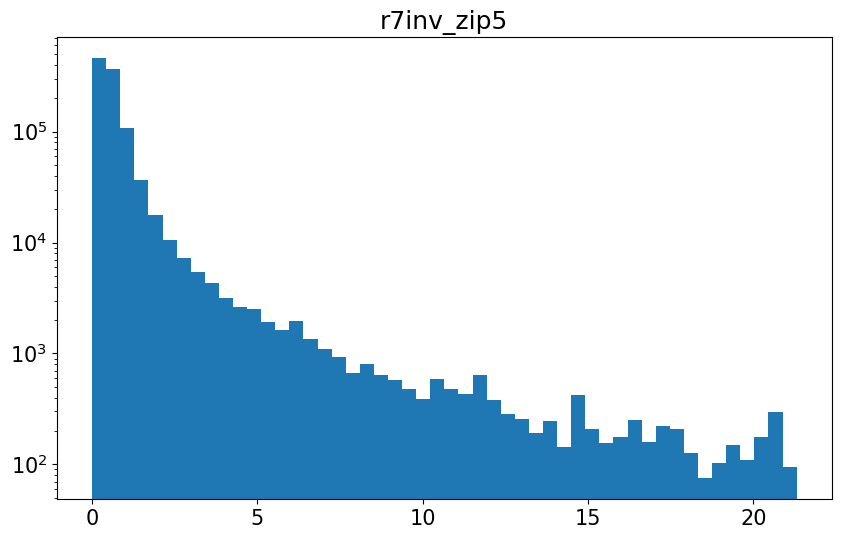

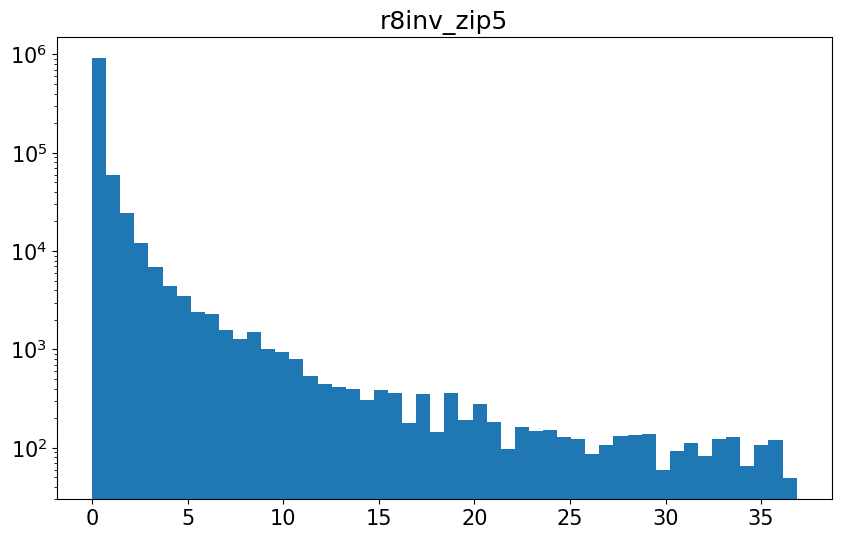

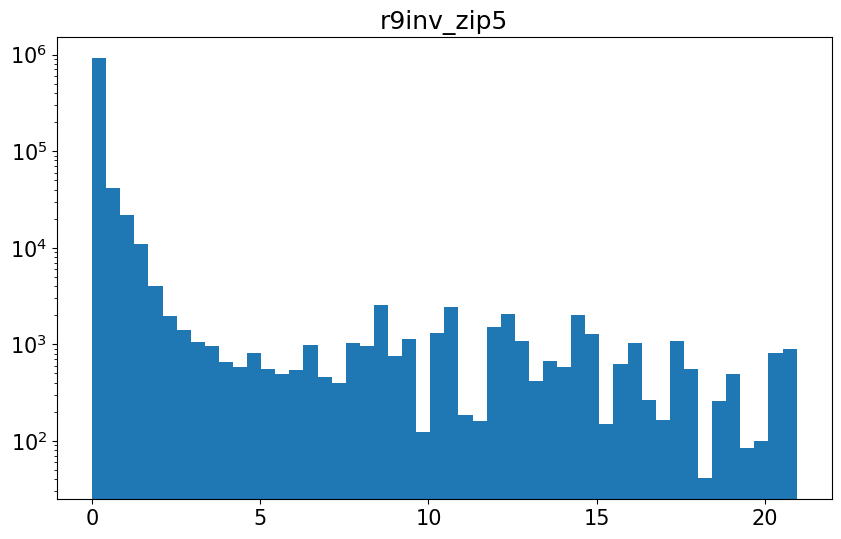

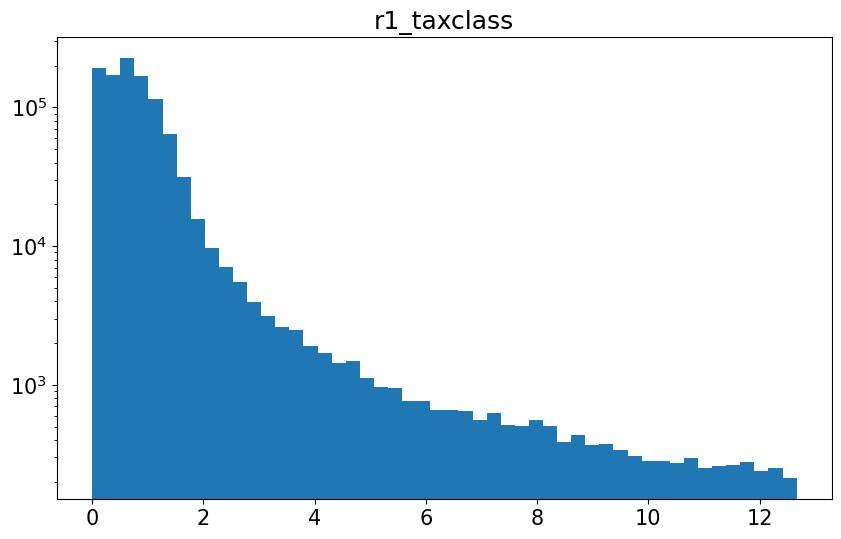

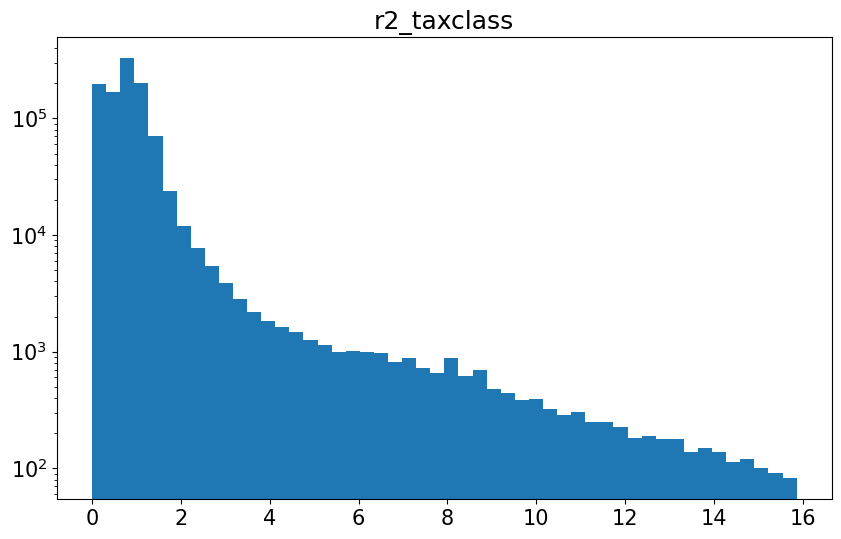

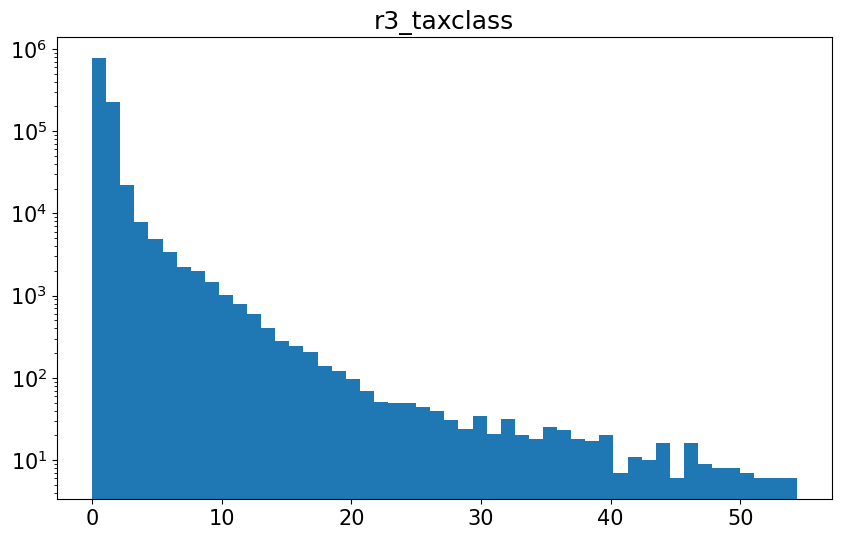

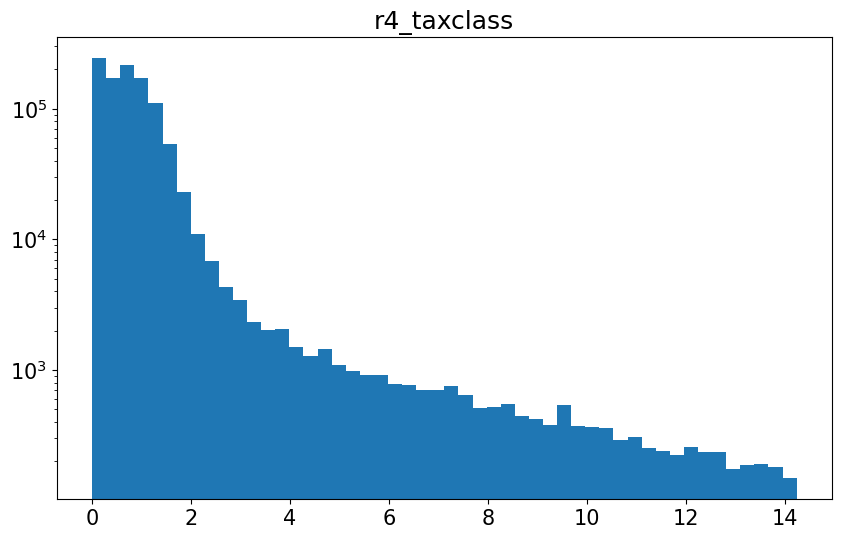

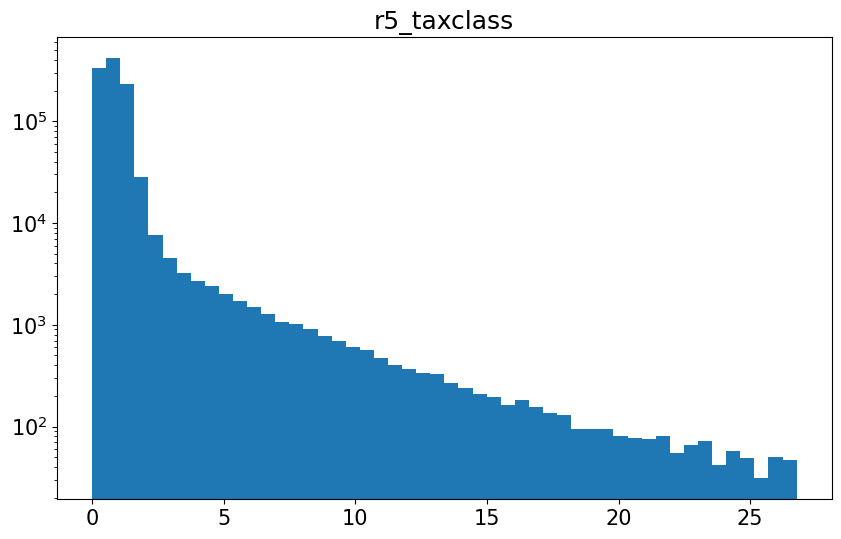

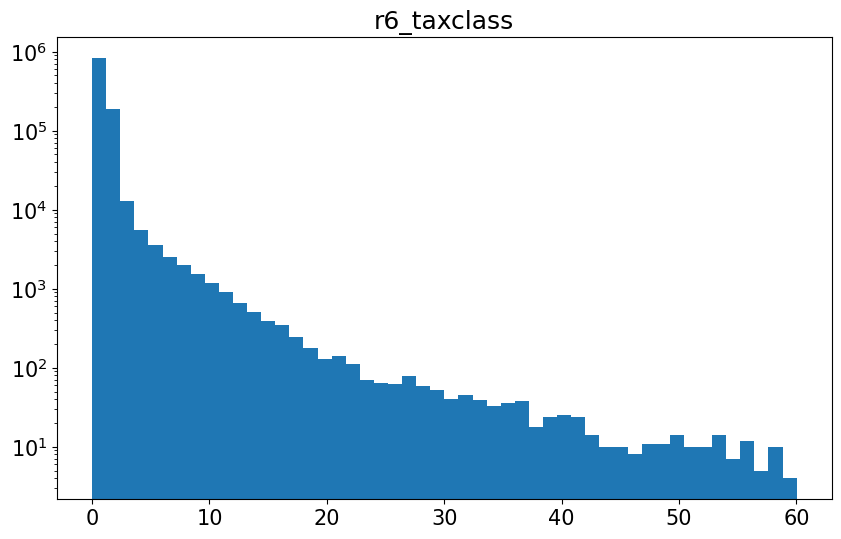

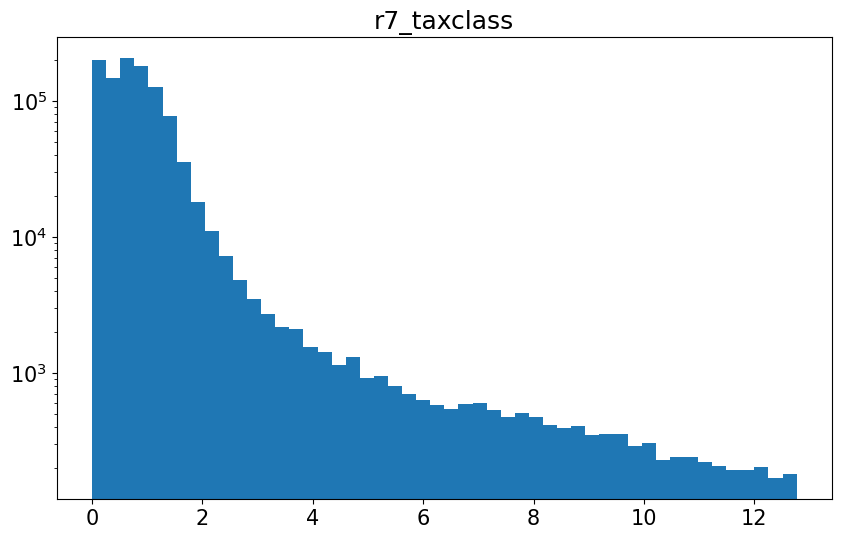

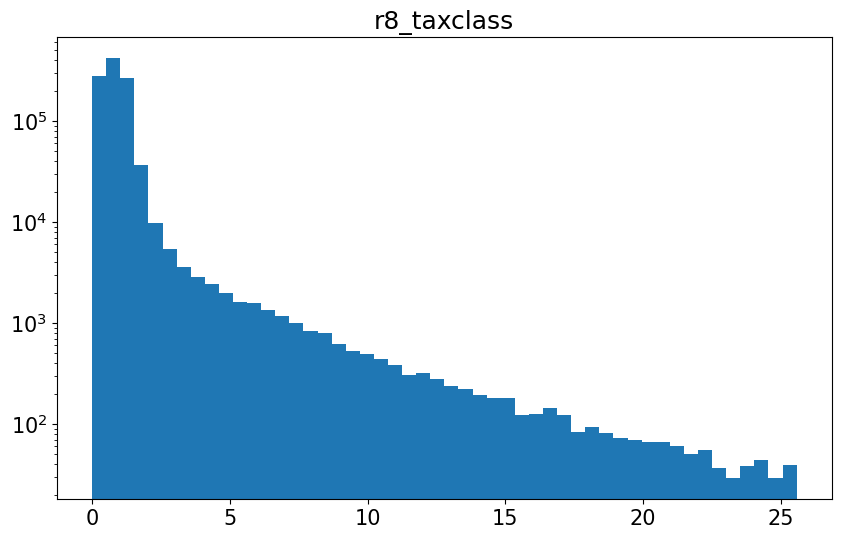

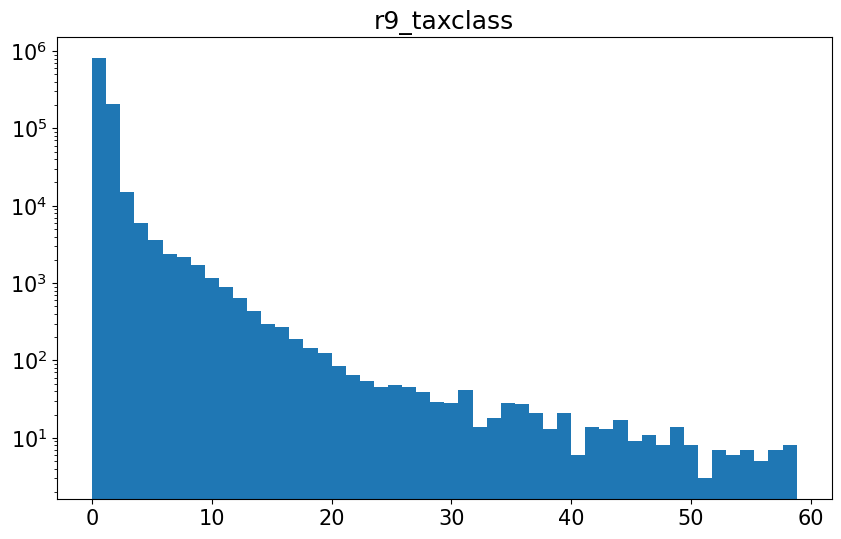

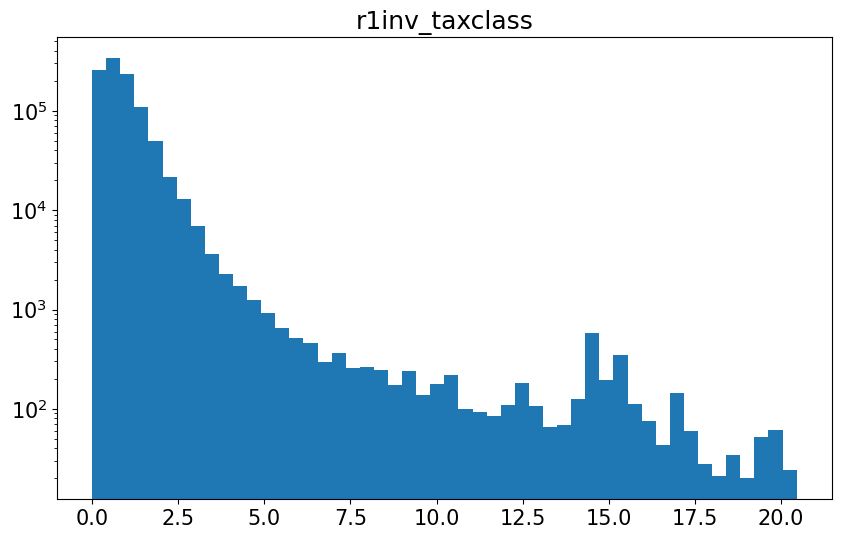

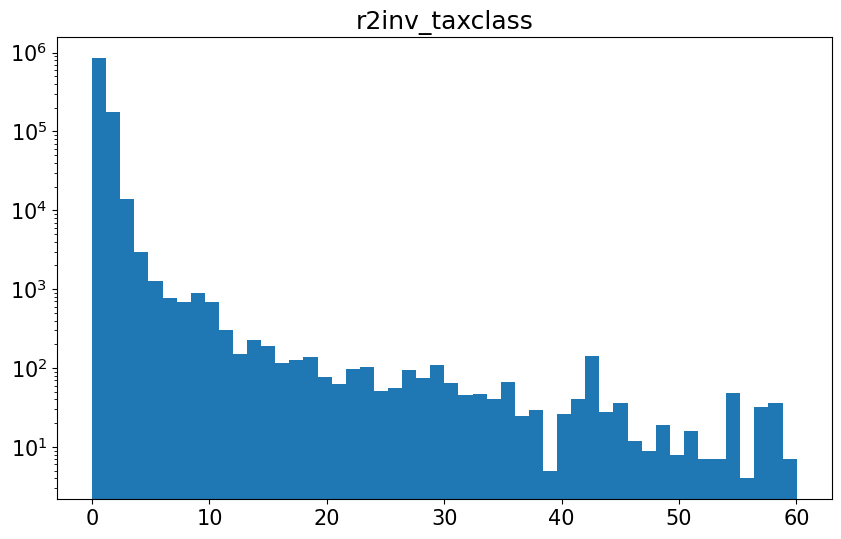

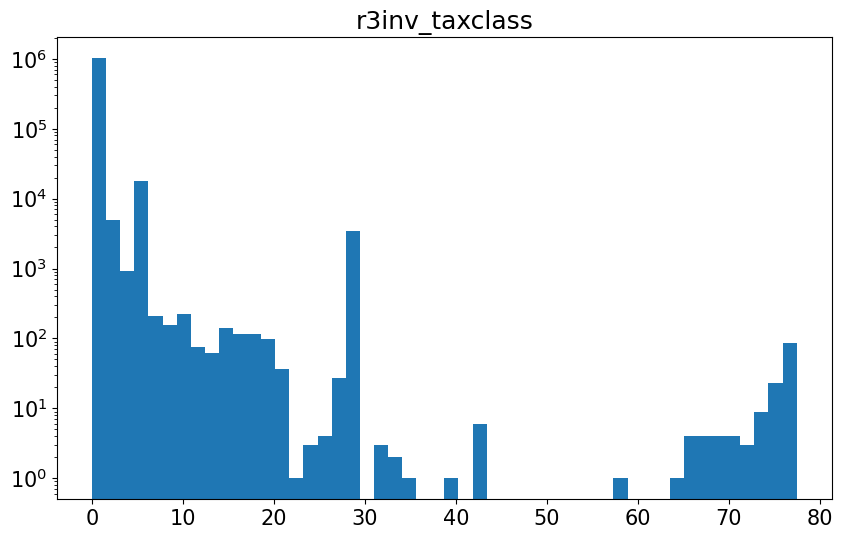

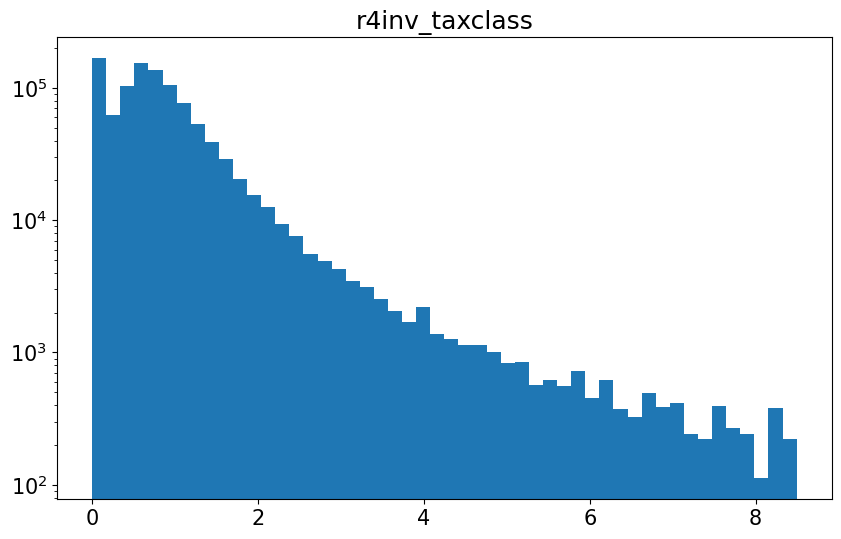

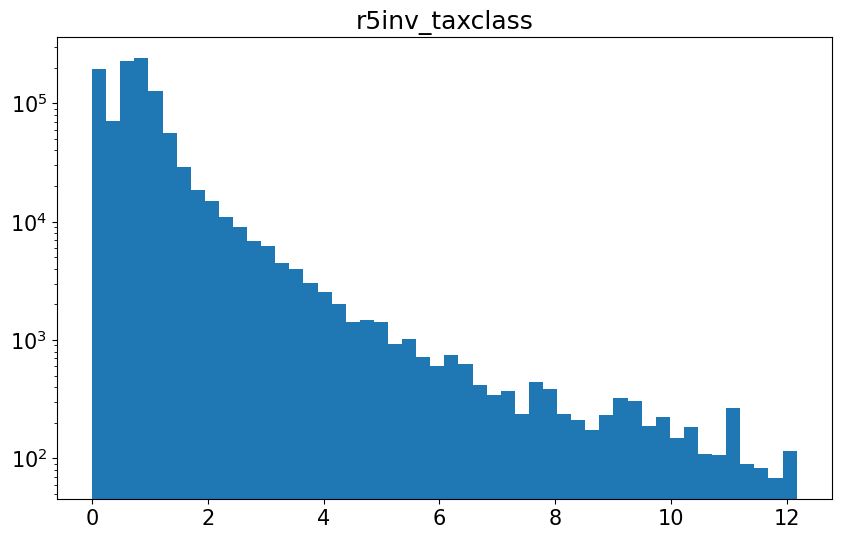

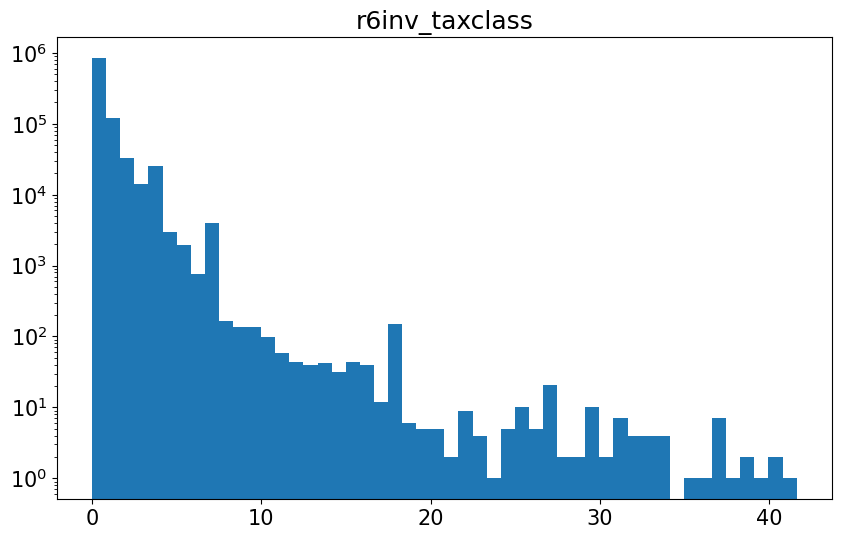

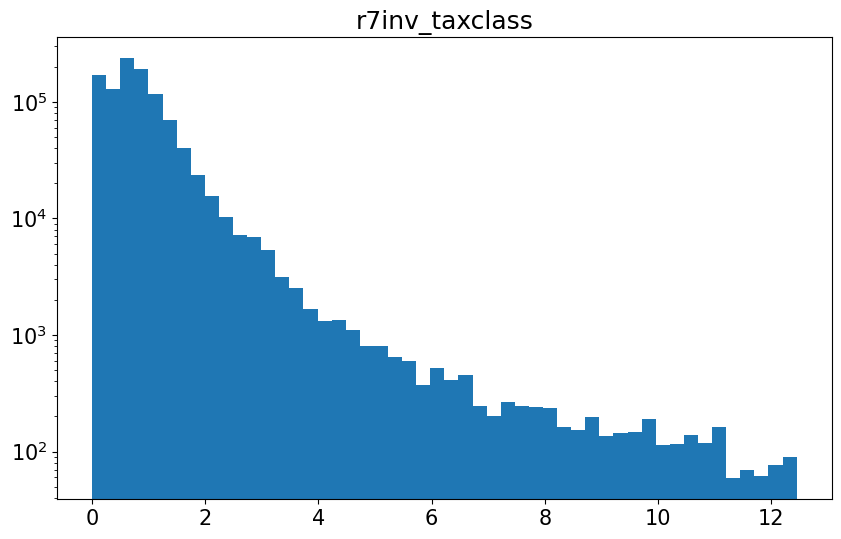

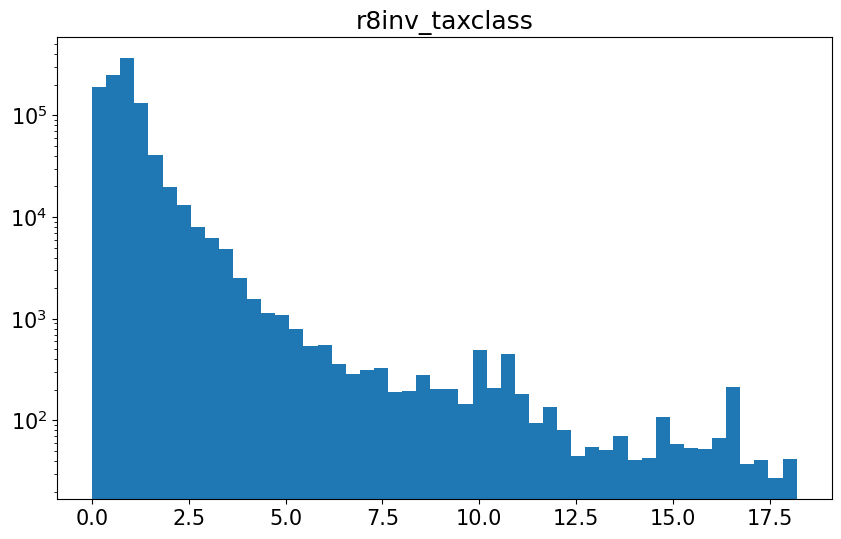

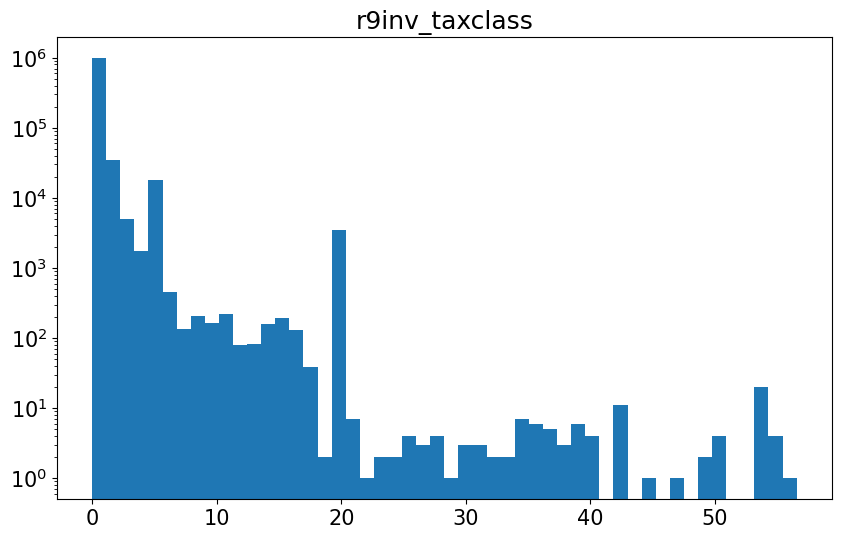

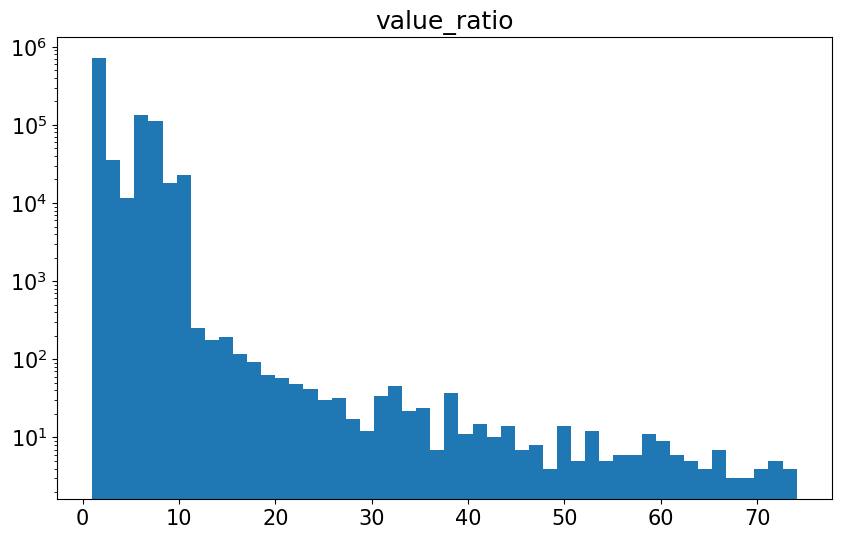

In [58]:
%%time
nstd = 4
for col in data.columns:
    plt.rcParams['figure.figsize'] = [10,6]
    plt.figure()
    plt.rcParams['font.size'] = 15
    plt.yscale('log')
    xstdev = data[col].std()
    xmean = data[col].mean()
    temp = data[data[col] <= xmean + nstd*xstdev]
    temp = temp[data[col] >= xmean - nstd*xstdev]
    plt.hist(temp[col],bins=50)
    plt.title(col)

In [59]:
data.to_csv('NY vars.csv', index=False)

In [315]:
data = pd.read_csv('NY vars.csv')

In [316]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046516 entries, 0 to 1046515
Data columns (total 95 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   exempt_ratio                1046516 non-null  float64
 1   smoothed_exempt_ratio_zip5  1046516 non-null  float64
 2   r1                          1046516 non-null  float64
 3   r2                          1046516 non-null  float64
 4   r3                          1046516 non-null  float64
 5   r4                          1046516 non-null  float64
 6   r5                          1046516 non-null  float64
 7   r6                          1046516 non-null  float64
 8   r7                          1046516 non-null  float64
 9   r8                          1046516 non-null  float64
 10  r9                          1046516 non-null  float64
 11  bldsizeinv                  1046516 non-null  float64
 12  bldvolinv                   1046516 non-null  float64
 1

In [317]:
data.columns

Index(['exempt_ratio', 'smoothed_exempt_ratio_zip5', 'r1', 'r2', 'r3', 'r4',
       'r5', 'r6', 'r7', 'r8', 'r9', 'bldsizeinv', 'bldvolinv', 'r1inv',
       'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv', 'r9inv',
       'r1_zip_mean', 'r2_zip_mean', 'r3_zip_mean', 'r4_zip_mean',
       'r5_zip_mean', 'r6_zip_mean', 'r7_zip_mean', 'r8_zip_mean',
       'r9_zip_mean', 'r1inv_zip_mean', 'r2inv_zip_mean', 'r3inv_zip_mean',
       'r4inv_zip_mean', 'r5inv_zip_mean', 'r6inv_zip_mean', 'r7inv_zip_mean',
       'r8inv_zip_mean', 'r9inv_zip_mean', 'r1_class_mean', 'r2_class_mean',
       'r3_class_mean', 'r4_class_mean', 'r5_class_mean', 'r6_class_mean',
       'r7_class_mean', 'r8_class_mean', 'r9_class_mean', 'r1inv_class_mean',
       'r2inv_class_mean', 'r3inv_class_mean', 'r4inv_class_mean',
       'r5inv_class_mean', 'r6inv_class_mean', 'r7inv_class_mean',
       'r8inv_class_mean', 'r9inv_class_mean', 'r1_zip5', 'r2_zip5', 'r3_zip5',
       'r4_zip5', 'r5_zip5', 'r6_zip5'

In [318]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,exempt_ratio,smoothed_exempt_ratio_zip5,r1,r2,r3,r4,r5,r6,r7,r8,...,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-1.629388e-12,-1.367307e-12,-5.386106e-14,-8.555897e-14,1.800776e-14,-8.595094e-15,2.902133e-15,4.689772e-15,-3.977902e-14,2.144410e-16,...,3.689106e-15,-4.974323e-18,6.436285e-15,2.256880e-14,3.480243e-14,-3.771961e-15,-5.053060e-15,1.667420e-14,-1.409753e-15,2.568678e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.973283e-01,-7.961769e-01,-3.943461e-01,-5.279615e-01,-4.980794e-01,-1.500359e-01,-6.205592e-02,-5.450713e-02,-1.326681e-01,-5.617348e-02,...,-2.044061e-01,-6.716933e-02,-4.290557e-02,-5.336106e-01,-3.580384e-01,-9.619550e-02,-3.491310e-01,-2.323032e-01,-7.120427e-02,-1.178351e-01
25%,-9.973283e-01,-7.961769e-01,-2.537727e-01,-3.224603e-01,-3.413922e-01,-1.164044e-01,-4.542776e-02,-4.508554e-02,-1.067606e-01,-3.740902e-02,...,-1.192618e-01,-3.298986e-02,-4.202757e-02,-3.160387e-01,-1.866933e-01,-6.753334e-02,-1.925470e-01,-1.043849e-01,-5.435476e-02,-1.110081e-01
50%,-4.899889e-01,-2.332393e-01,-1.135917e-01,-4.246958e-02,-7.204698e-03,-8.448534e-02,-2.196899e-02,-1.354895e-02,-9.059708e-02,-2.720805e-02,...,-5.599211e-02,-1.222182e-02,-4.163930e-02,-1.495618e-01,-8.766857e-02,-5.447817e-02,-9.315368e-02,-4.853776e-02,-4.730808e-02,-1.019706e-01
75%,1.066691e+00,5.138732e-01,5.236643e-02,1.363181e-01,1.924975e-01,-4.701529e-02,-7.778773e-03,3.146249e-03,-6.633472e-02,-1.752098e-02,...,2.578394e-02,6.719256e-03,-4.052659e-02,7.117158e-02,1.859422e-02,-3.164344e-02,3.548849e-02,1.412338e-02,-3.734685e-02,1.640043e-01
max,1.066691e+00,8.741506e+01,2.485789e+02,3.003557e+02,4.685327e+02,3.138135e+02,8.957987e+02,6.453387e+02,3.102425e+02,9.359972e+02,...,4.052931e+02,7.603559e+02,1.296153e+02,1.899533e+02,4.306807e+02,3.431575e+01,2.113522e+02,4.599485e+02,4.797454e+01,5.617681e+02


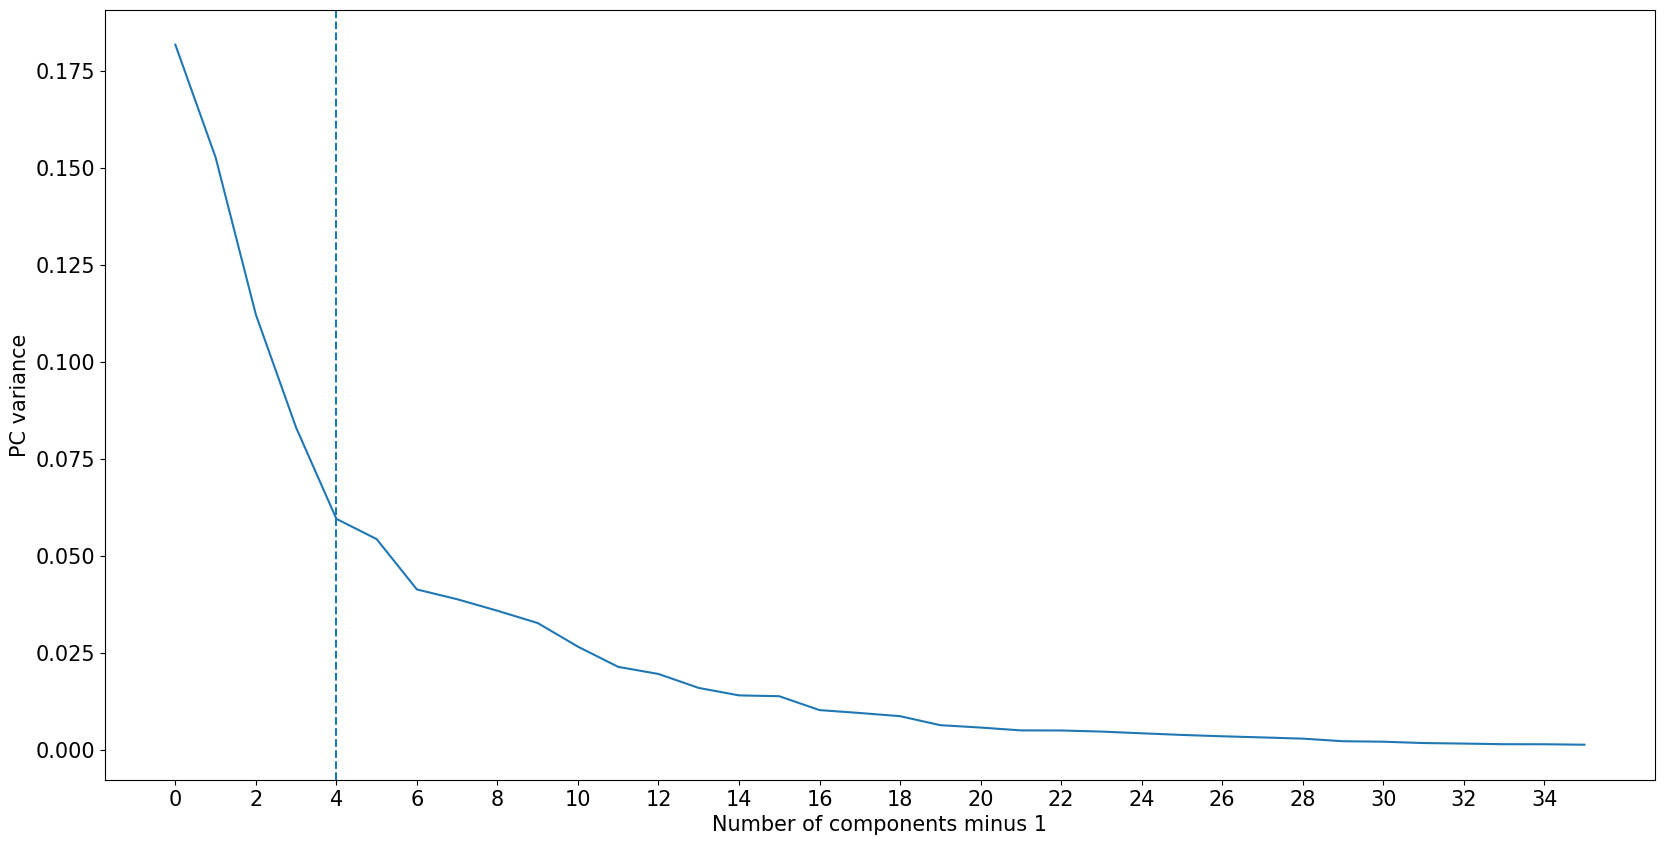

In [319]:
# do a PCA and look at the cumulative variance plot
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

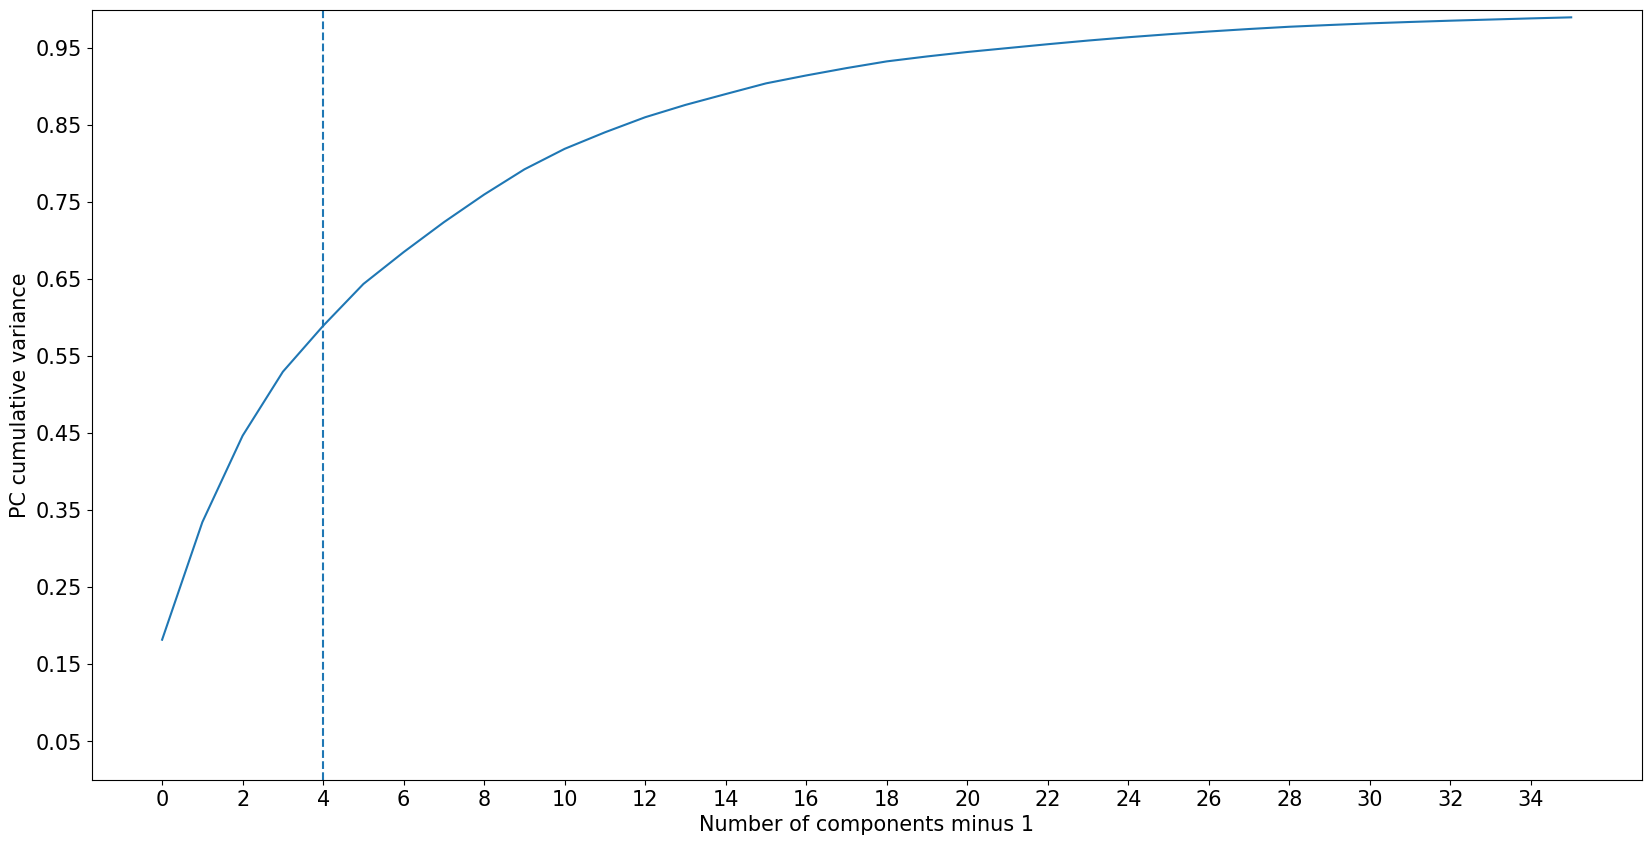

In [320]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [321]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 12.9 s, sys: 4.19 s, total: 17.1 s
Wall time: 4.28 s


4

In [322]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.18180567 0.33456021 0.44678874 0.52988261]


In [323]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1046516, 4)

In [324]:
data_pca.head(5)

,PC1,PC2,PC3,PC4
0,3.218873,4.419827,0.202357,-9.078221
1,124.367271,26.931739,196.020322,25.579966
2,0.792510,-0.982656,0.625499,-0.116721
3,1.570171,-0.777830,1.245491,-0.005675
4,3.197452,-0.366845,2.535821,0.270415


In [325]:
data_pca.describe()

,PC1,PC2,PC3,PC4
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,5.742380e-17,-1.758140e-16,-2.681406e-15,-1.206192e-15
std,4.155904e+00,3.809420e+00,3.265228e+00,2.809612e+00
min,-1.411010e+02,-2.767188e+00,-9.374385e+02,-2.552177e+02
25%,-4.482038e-01,-8.203747e-01,-5.582974e-01,1.264512e-01
50%,1.113693e-01,-6.728283e-01,-3.143015e-01,4.333180e-01
75%,4.491580e-01,-3.728893e-01,2.787707e-02,5.647547e-01
max,2.249996e+03,9.718743e+02,9.545092e+02,2.612091e+02


In [326]:
# zscale the pcs. This is an optional step, and I like to make all the retained PCs equally important.
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-3.169243e-16,-3.977396e-16,-1.420869e-15,-1.759999e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.395194e+01,-7.264066e-01,-2.870974e+02,-9.083736e+01
25%,-1.078475e-01,-2.153542e-01,-1.709827e-01,4.500666e-02
50%,2.679784e-02,-1.766222e-01,-9.625715e-02,1.542270e-01
75%,1.080771e-01,-9.788612e-02,8.537559e-03,2.010081e-01
max,5.413974e+02,2.551240e+02,2.923255e+02,9.296983e+01


In [327]:
data_pca_zs.shape

(1046516, 4)

In [328]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4
0,0.774530,1.160236,0.061973,-3.231130
1,29.925443,7.069774,60.032669,9.104449
2,0.190695,-0.257954,0.191564,-0.041544
3,0.377817,-0.204186,0.381441,-0.002020
4,0.769376,-0.096299,0.776614,0.096246


## Now calculate two unsupervised fraud scores

In [329]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Good choices are anywhere from 1 to about 4.
p1 = 2
p2 = 1
ntop = 10000

### Calculate score 1

In [330]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0     3.519956
1    68.061194
2     0.375935
3     0.574403
4     1.101637
5     0.394366
6     0.316269
7     0.319537
8     0.857653
9     0.827789
dtype: float64

In [331]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4
0,0.774530,1.160236,0.061973,-3.231130
1,29.925443,7.069774,60.032669,9.104449
2,0.190695,-0.257954,0.191564,-0.041544
3,0.377817,-0.204186,0.381441,-0.002020
4,0.769376,-0.096299,0.776614,0.096246
5,-0.126604,-0.333317,-0.122855,-0.115336
6,0.016524,-0.305234,0.016151,-0.079527
7,0.002892,-0.308646,0.002560,-0.082624
8,0.593736,-0.140983,0.601094,0.043083
9,0.571840,-0.147422,0.578805,0.038522


In [332]:
score1.max()

669.9818789603765

### Autoencoder for score 2

In [333]:
%%time
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: user 30.8 s, sys: 199 ms, total: 31 s
Wall time: 31.2 s


/Users/terryxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [334]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [335]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,3.519956,2.262706,1
1,68.061194,54.746178,2
2,0.375935,0.122290,9
3,0.574403,0.165322,10
4,1.101637,0.304752,11
5,0.394366,0.212030,12
6,0.316269,0.171399,13
7,0.319537,0.175302,14
8,0.857653,0.236996,15
9,0.827789,0.230054,16


In [336]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,3.519956,2.262706,1,1013406.0,1040168.0
1,68.061194,54.746178,2,1046453.0,1046411.0
2,0.375935,0.122290,9,684740.0,491745.0
3,0.574403,0.165322,10,903992.0,637837.0
4,1.101637,0.304752,11,958731.0,927884.0
5,0.394366,0.212030,12,734376.0,797437.0
6,0.316269,0.171399,13,459996.0,661580.0
7,0.319537,0.175302,14,479618.0,677337.0
8,0.857653,0.236996,15,945105.0,869677.0
9,0.827789,0.230054,16,943001.0,851327.0


In [337]:
# calculate the final score as the average of the two scores
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
0,3.519956,2.262706,1,1013406.0,1040168.0,1026787.0
1,68.061194,54.746178,2,1046453.0,1046411.0,1046432.0
2,0.375935,0.122290,9,684740.0,491745.0,588242.5
3,0.574403,0.165322,10,903992.0,637837.0,770914.5
4,1.101637,0.304752,11,958731.0,927884.0,943307.5
5,0.394366,0.212030,12,734376.0,797437.0,765906.5
6,0.316269,0.171399,13,459996.0,661580.0,560788.0
7,0.319537,0.175302,14,479618.0,677337.0,578477.5
8,0.857653,0.236996,15,945105.0,869677.0,907391.0
9,0.827789,0.230054,16,943001.0,851327.0,897164.0


In [338]:
scores_sorted.head(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
898718,669.981879,1171.244937,917942,1046516.0,1046516.0,1046516.0
1036106,310.856255,386.783980,1059883,1046515.0,1046515.0,1046515.0
648311,221.425481,374.335158,665158,1046512.0,1046514.0,1046513.0
667756,244.197310,295.266778,684704,1046514.0,1046512.0,1046513.0
115113,233.996175,286.268613,116647,1046513.0,1046511.0,1046512.0
11984,185.977979,300.364314,12076,1046510.0,1046513.0,1046511.5
317851,178.449357,284.266164,330291,1046509.0,1046510.0,1046509.5
137438,216.416899,252.829083,139726,1046511.0,1046507.0,1046509.0
622385,161.378425,271.424587,638993,1046506.0,1046509.0,1046507.5
527185,153.210691,266.150498,542924,1046505.0,1046508.0,1046506.5


In [339]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
324208,0.160073,0.014100,336798,762.0,36.0,399.0
345057,0.158447,0.012404,357895,675.0,8.0,341.5
250928,0.157225,0.014762,262185,597.0,66.0,331.5
841979,0.155462,0.014390,860294,533.0,46.0,289.5
338993,0.155075,0.013993,351800,526.0,31.0,278.5
841978,0.154650,0.009249,860293,500.0,1.0,250.5
841977,0.154557,0.011349,860292,496.0,4.0,250.0
411800,0.152338,0.010998,426737,427.0,3.0,215.0
477337,0.145247,0.012753,492696,256.0,10.0,133.0
691686,0.139047,0.014630,708934,157.0,57.0,107.0


In [340]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,6.571284e-01,2.291411e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,1.888963e+00,1.932761e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.803638e+05
min,1.036366e-01,9.249457e-03,1.000000e+00,1.000000e+00,1.000000e+00,1.070000e+02
25%,2.842055e-01,7.648007e-02,2.731068e+05,2.616309e+05,2.616280e+05,2.793151e+05
50%,3.276368e-01,1.311802e-01,5.389795e+05,5.232592e+05,5.232585e+05,4.994450e+05
75%,4.136550e-01,2.075462e-01,8.026112e+05,7.848840e+05,7.848872e+05,7.675112e+05
max,6.699819e+02,1.171245e+03,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [341]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,6.571284e-01,2.291411e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,1.888963e+00,1.932761e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.803638e+05
min,1.036366e-01,9.249457e-03,1.000000e+00,1.000000e+00,1.000000e+00,1.070000e+02
25%,2.842055e-01,7.648007e-02,2.731068e+05,2.616309e+05,2.616280e+05,2.793151e+05
50%,3.276368e-01,1.311802e-01,5.389795e+05,5.232592e+05,5.232585e+05,4.994450e+05
75%,4.136550e-01,2.075462e-01,8.026112e+05,7.848840e+05,7.848872e+05,7.675112e+05
max,6.699819e+02,1.171245e+03,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [342]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,669.981879,1171.244937,1046516.0,1046516.0,1046516.0
1059883,310.856255,386.783980,1046515.0,1046515.0,1046515.0
665158,221.425481,374.335158,1046512.0,1046514.0,1046513.0
684704,244.197310,295.266778,1046514.0,1046512.0,1046513.0
116647,233.996175,286.268613,1046513.0,1046511.0,1046512.0
12076,185.977979,300.364314,1046510.0,1046513.0,1046511.5
330291,178.449357,284.266164,1046509.0,1046510.0,1046509.5
139726,216.416899,252.829083,1046511.0,1046507.0,1046509.0
638993,161.378425,271.424587,1046506.0,1046509.0,1046507.5


(0.1, 2074039.188412121)

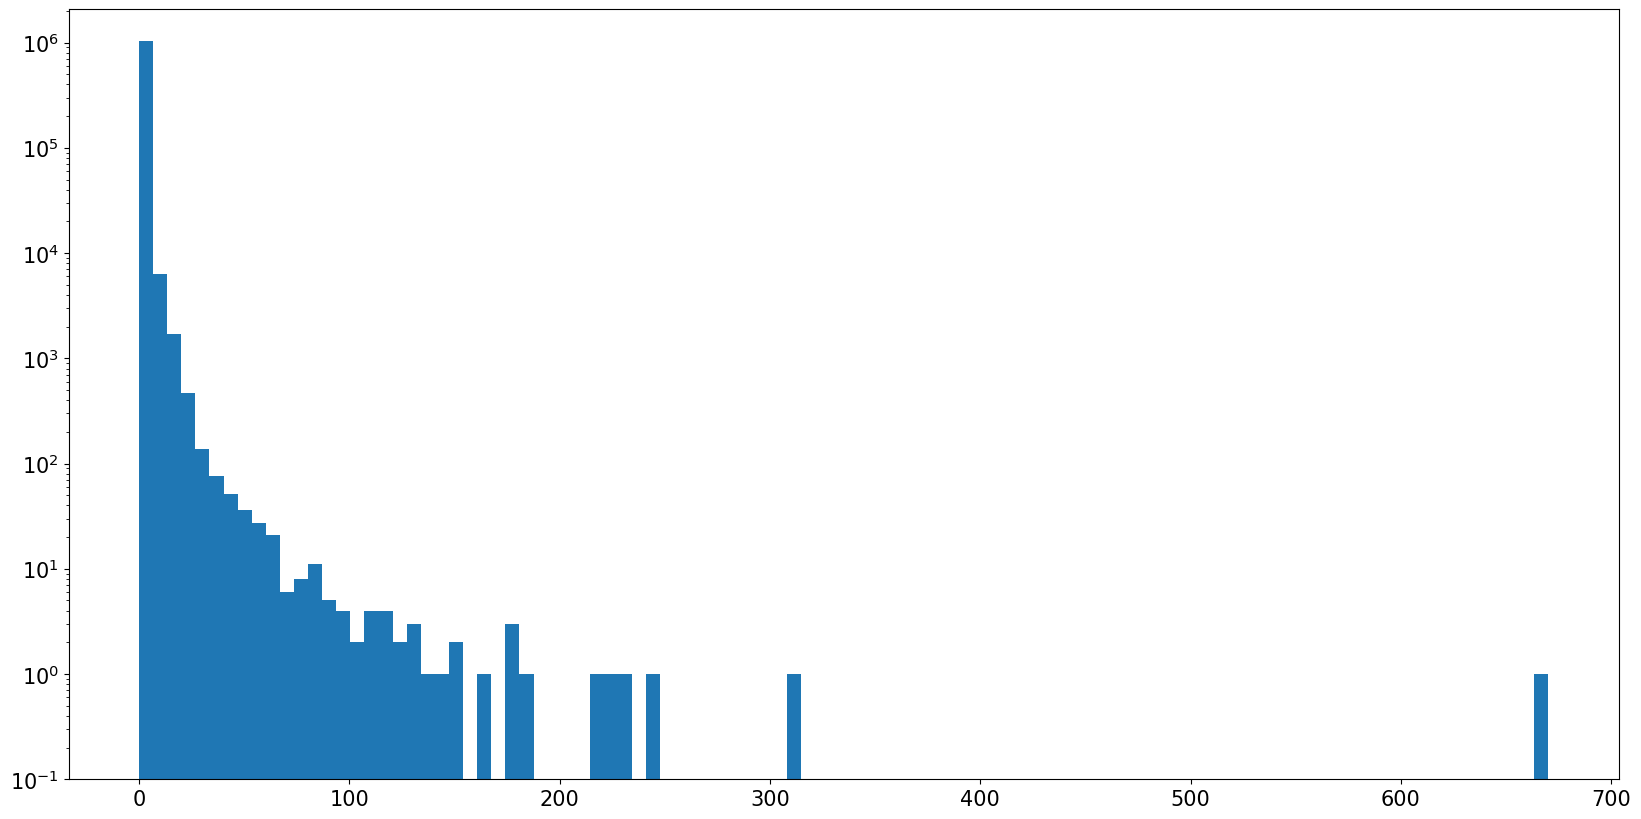

In [343]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [344]:
sc2max = int(score2.max())
sc2max

1171

1171


(0.1, 2091121.2133379462)

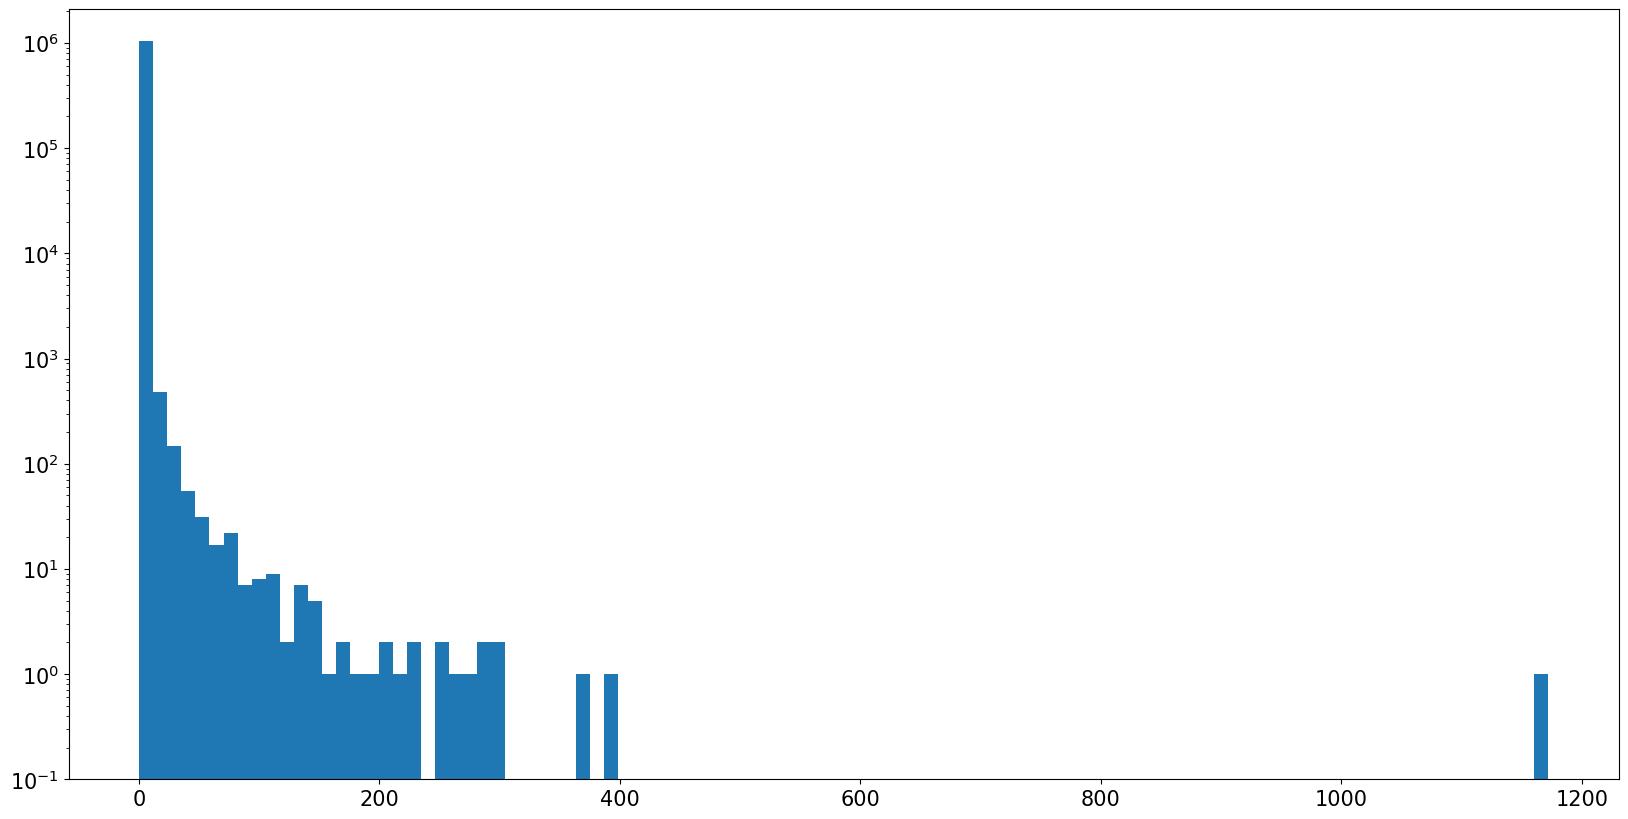

In [345]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

(array([  589.,  2270.,  3612.,  5163.,  5760.,  6239.,  6321.,  6417.,
         6309.,  6688.,  6758.,  7897.,  8486.,  9097., 10489., 11700.,
        12641., 13951., 14369., 14808., 14973., 14678., 15966., 15123.,
        15238., 15588., 15389., 15546., 14527., 14538., 14198., 14211.,
        13849., 13334., 12806., 12876., 12380., 11532., 11364., 11289.,
        11280., 10995., 11077., 10892., 10938., 10886., 10436., 10597.,
        10527., 10088., 10070.,  9517.,  9736.,  9443.,  9523.,  9263.,
         9213.,  9119.,  9051.,  9011.,  8741.,  8605.,  8507.,  8451.,
         8324.,  9049.,  9967., 10755., 12536., 12486., 13520., 13966.,
        14485., 15426., 15697., 14444., 16038., 15429., 13290., 11962.,
        10649., 10160.,  8695.,  5925.,  5196.,  5304.,  4915.,  5480.,
         5719.,  6069.,  6795.,  6636.,  6788.,  9426., 15227., 18784.,
        11828.,  6425.,  8095.,  6091.]),
 array([1.07000000e+02, 1.05710900e+04, 2.10351800e+04, 3.14992700e+04,
        4.19633600e+04

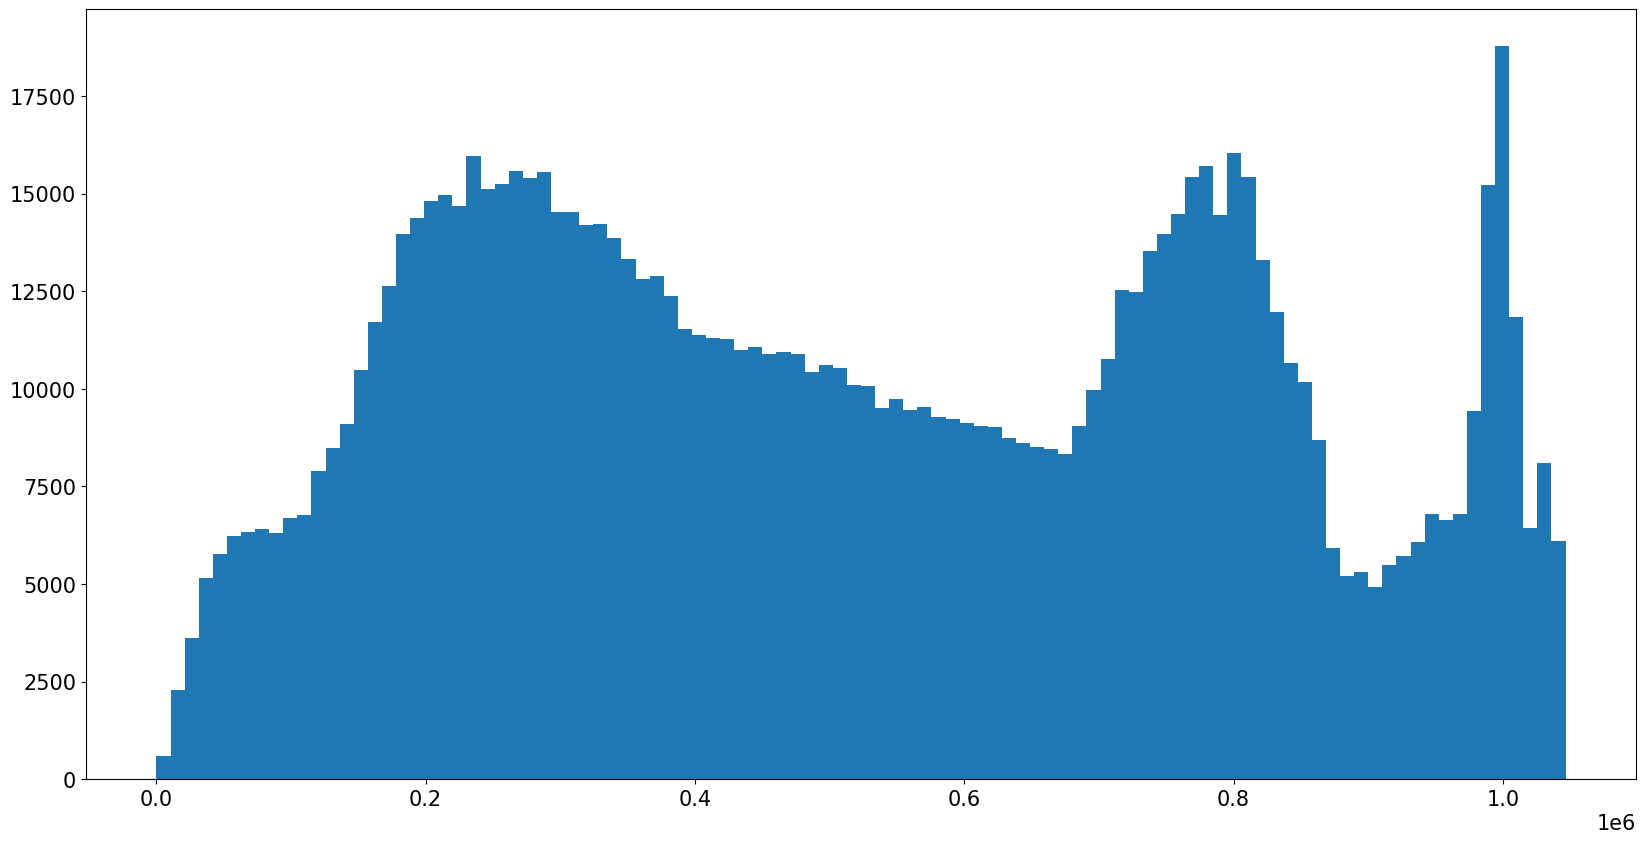

In [346]:
plt.hist(scores['final'],bins=100)

In [347]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Int64Index([ 917942, 1059883,  665158,  684704,  116647,   12076,  330291,
             139726,  638993,  542924,
            ...
             100941,  970482,   18728,   18730,   18726,   18731,   18732,
              18729,   18733,   18734],
           dtype='int64', name='RECORD', length=10000)


In [348]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,exempt_ratio,smoothed_exempt_ratio_zip5,r1,r2,r3,r4,r5,r6,r7,r8,...,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,-0.091668,16.018283,-0.319263,3.342098,-0.498076,-0.034904,2.049412,-0.054505,-0.042508,1.874760,...,-0.191686,-0.067120,0.147390,-0.511049,-0.357821,0.287757,-0.325066,-0.232104,0.251795,0.268647
2,-0.658650,5.491706,105.627227,34.519595,-0.498052,60.644285,7.088604,-0.054501,127.176564,17.430504,...,-0.204401,-0.067164,0.050640,-0.533576,-0.357975,0.263497,-0.349121,-0.232282,0.144018,0.189694
9,-0.997328,-0.796177,0.315043,0.185424,-0.467700,0.738281,0.255797,-0.040768,0.719157,0.299764,...,-0.203063,-0.066896,-0.042758,-0.530691,-0.356595,-0.094540,-0.346589,-0.231220,-0.070686,0.245771
10,-0.997328,-0.796177,0.630856,0.503016,-0.454176,1.133751,0.397303,-0.034651,1.098382,0.458224,...,-0.203478,-0.066981,-0.042803,-0.531592,-0.357039,-0.095048,-0.347374,-0.231554,-0.070845,0.245771
11,-0.997328,-0.796177,1.511860,1.388984,-0.416447,1.201097,0.421400,-0.033610,2.156279,0.900270,...,-0.203909,-0.067068,-0.042850,-0.531693,-0.357089,-0.095105,-0.348189,-0.231900,-0.071011,0.200975


In [349]:
data_zs_top_n = data_zs.loc[top_records]
data_zs_top_n.transpose()

RECORD,917942,1059883,665158,684704,116647,12076,330291,139726,638993,542924,...,100941,970482,18728,18730,18726,18731,18732,18729,18733,18734
exempt_ratio,-0.204666,-0.997328,1.055792,-0.997328,-0.997328,-0.997328,-0.397998,-0.997328,-0.997328,-0.997328,...,-0.997328,-0.997328,-0.997328,-0.997328,-0.997328,-0.997328,-0.997328,-0.997328,-0.997328,-0.997328
smoothed_exempt_ratio_zip5,-0.333872,-0.796177,0.317456,-0.796177,-0.796177,-0.796177,0.502806,-0.796177,-0.796177,-0.796177,...,-0.796177,-0.796177,-0.796177,-0.796177,-0.796177,-0.796177,-0.796177,-0.796177,-0.796177,-0.796177
r1,0.730821,198.784241,-0.379280,171.257007,157.171035,0.037126,-0.216893,248.578888,-0.339343,-0.247547,...,7.348460,2.569620,-0.393924,-0.393924,-0.393924,-0.393924,-0.393924,-0.393924,-0.393924,-0.393924
r2,67.111269,-0.037223,131.063046,-0.417009,4.355871,100.559752,271.798855,-0.037223,74.639081,-0.421118,...,5.454582,-0.037223,-0.527013,-0.527013,-0.527013,-0.527013,-0.527013,-0.527013,-0.527013,-0.527013
r3,47.508353,-0.498079,279.689086,-0.498079,-0.200971,214.740641,144.463344,-0.498079,159.549640,-0.422248,...,2.049560,-0.498079,-0.497742,-0.497742,-0.497742,-0.497742,-0.497742,-0.497742,-0.497742,-0.497742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
r6inv_taxclass,-0.096196,0.297729,-0.096195,0.000004,-0.095804,-0.096195,-0.096195,0.297729,-0.096195,-0.095474,...,-0.087551,0.297729,0.078872,0.078872,0.078872,0.078872,0.078872,0.078872,0.078872,0.078872
r7inv_taxclass,-0.349080,-0.349129,-0.229437,-0.349088,-0.349118,-0.344947,-0.338950,-0.349131,-0.316285,-0.309237,...,-0.337706,-0.348550,3.548431,3.548431,3.548431,3.548431,3.548431,3.548431,3.548431,3.548431
r8inv_taxclass,-0.232303,-0.230787,-0.232298,-0.214578,-0.231918,-0.232296,-0.232301,-0.230787,-0.232293,-0.219745,...,-0.214387,-0.230787,0.563709,0.563709,0.563709,0.563709,0.563709,0.563709,0.563709,0.563709
r9inv_taxclass,-0.071204,0.270225,-0.071204,0.000003,-0.070982,-0.071204,-0.071204,0.270225,-0.071204,-0.070670,...,-0.065997,0.270225,-0.029978,-0.029978,-0.029978,-0.029978,-0.029978,-0.029978,-0.029978,-0.029978


In [350]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
1,1013406.0,1040168.0,1026787.0
2,1046453.0,1046411.0,1046432.0
9,684740.0,491745.0,588242.5
10,903992.0,637837.0,770914.5
11,958731.0,927884.0,943307.5
12,734376.0,797437.0,765906.5
13,459996.0,661580.0,560788.0
14,479618.0,677337.0,578477.5
15,945105.0,869677.0,907391.0


In [351]:
# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1013406.0,1040168.0,1026787.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046453.0,1046411.0,1046432.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,724860.0,552315.0,638587.5
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,946395.0,886919.0,916657.0
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,917846.0,919021.0,918433.5
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,807704.0,904405.0,856054.5


In [352]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_and_sorted.set_index('RECORD',inplace=True)
NY_data_top_n = NY_data_scored_and_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046516.0,1046516.0,1046516.0
1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046515.0,1046515.0,1046515.0
665158,4030720001,4,3072,1,NaN,ST JOHNS CEMETERY,Z8,4,1412,2532,...,1.180764e+07,1.174500e+07,1.180764e+07,NaN,FINAL,2010/11,AC-TR,1046512.0,1046514.0,1046513.0
684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2,2,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046514.0,1046512.0,1046513.0
116647,1015410021,1,1541,21,NaN,MF ASSOCIATES OF NEW,D6,2,25,75,...,6.696000e+07,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046513.0,1046511.0,1046512.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18727,1003921104,1,392,1104,NaN,"BRANDRICK, JEREMY C",R5,4,0,0,...,1.041000e+03,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1037199.5,1024535.5,1030867.5
18728,1003921105,1,392,1105,NaN,"LAMB, SEAN T",R5,4,0,0,...,1.041000e+03,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1037199.5,1024535.5,1030867.5
18729,1003921106,1,392,1106,NaN,"HICKEY, EMILY K",R5,4,0,0,...,1.041000e+03,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1037199.5,1024535.5,1030867.5


In [353]:
NY_data_with_scores.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1013406.0,1040168.0,1026787.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046453.0,1046411.0,1046432.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
5,6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,...,4268700.0,4268700.0,4268700.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
6,7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,...,3546900.0,3546900.0,3546900.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
7,8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,...,11304000.0,9882000.0,11304000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
8,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,684740.0,491745.0,588242.5
9,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,903992.0,637837.0,770914.5


In [354]:
NY_data_top_n['OWNER'].head(40)

RECORD
917942      LOGAN PROPERTY, INC.
1059883                      NaN
665158         ST JOHNS CEMETERY
684704                  W RUFERT
116647      MF ASSOCIATES OF NEW
12076      15 WORTH STREET PROPE
330291           PRATT INSTITUTE
139726     BRADHURST EQUITIES, L
638993     ALEXANDER'S OF REGOPA
542924     BEN DAVID ENTERPRISES
106681           79TH REALTY LLC
665157         ST JOHNS CEMETERY
252834                       NaN
330292           PRATT INSTITUTE
33564        HLP PROPERTIES, LLC
39770      GREENHORN DEVELOPMENT
956520         TROMPETA RIZALINA
95995        BERGAMINI, JENNIFER
151044                       NaN
658933           WAN CHIU CHEUNG
820884     JAMAICA FIRST PARKING
288274                       NaN
86946       712 FIFTH AVENUE L P
48221        H & P 29TH ST ASSOC
610682            DEBORAH WILSON
14979           ENJAY ASSOCIATES
33751             GUIDARA, FRANK
980276     WOODMONT WEST HOA INC
649717                 57-43 LLC
1065870    PEOPLE OF THE ST OF N
712

In [355]:
NY_data_top_n.shape

(10000, 34)

In [356]:
data_zs_top_n.shape

(10000, 95)

In [357]:
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

(10003, 129)

In [358]:
NY_top_with_zs.to_excel('NY_top_with_zs.xlsx', index=True)
NY_data_top_n.to_excel('NY_top.xlsx', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

In [359]:
data_zs_top_n.shape

(10000, 95)

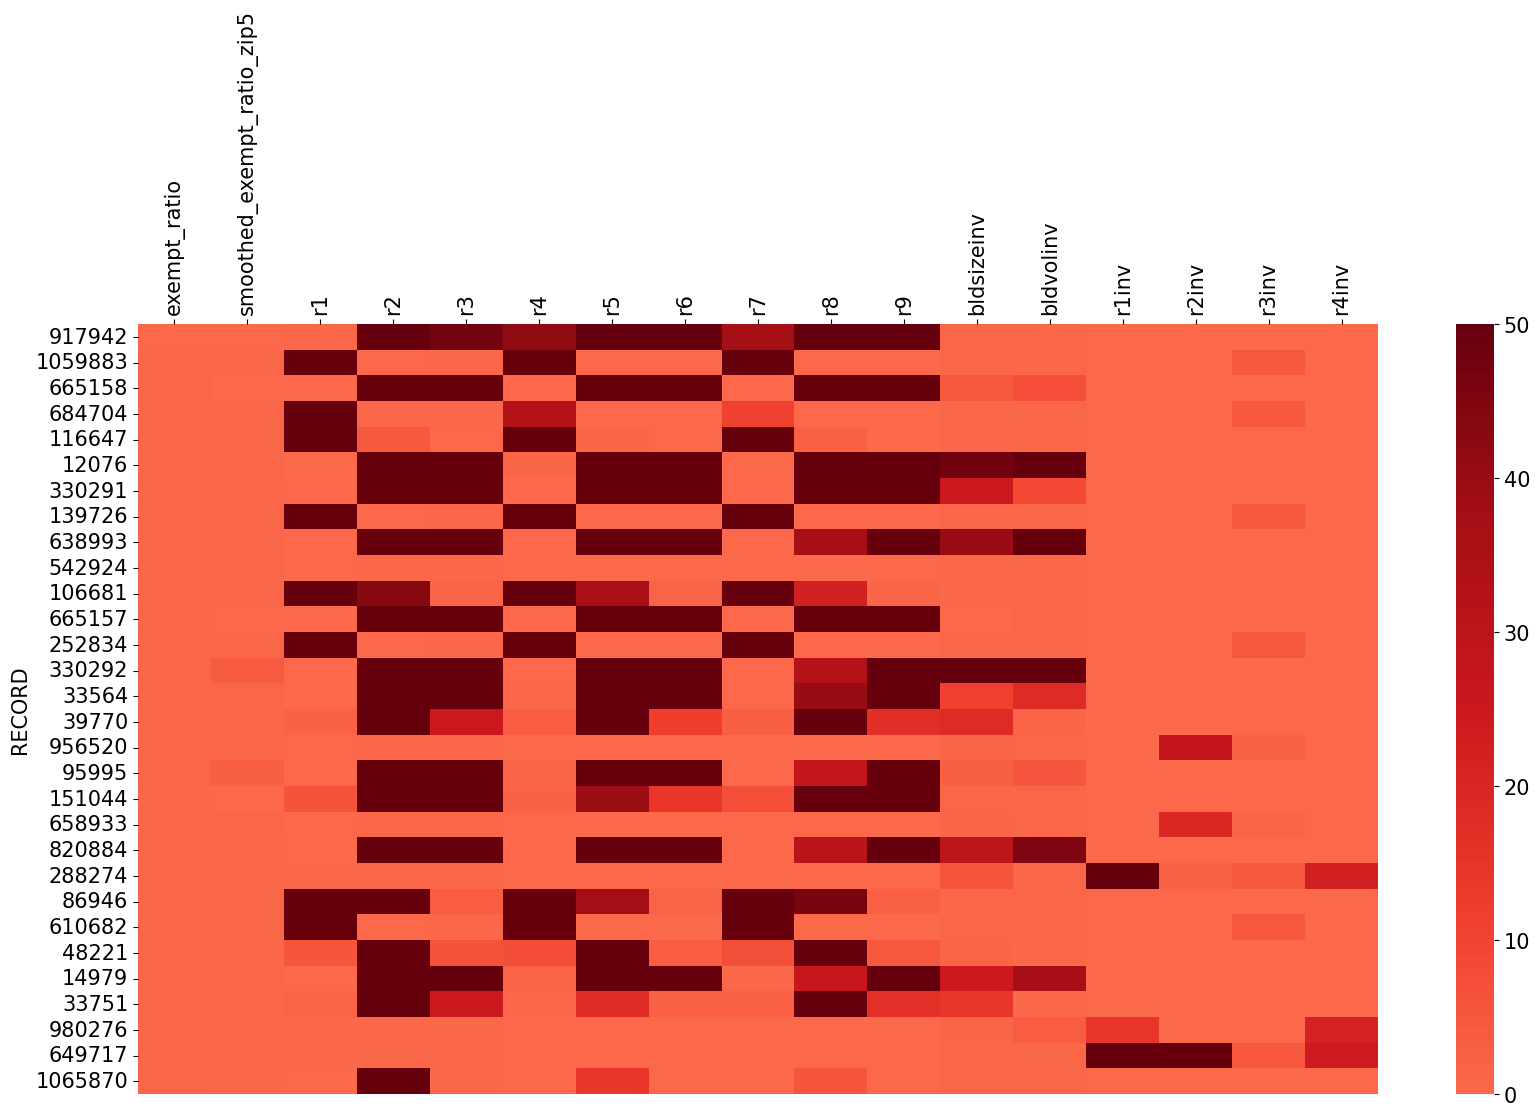

In [360]:
# The heatmaps are good for seeing which variables are driving the high scores
data_base_vars = data_zs_top_n.iloc[:,0:17].abs()
data_heatmap = data_base_vars.head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

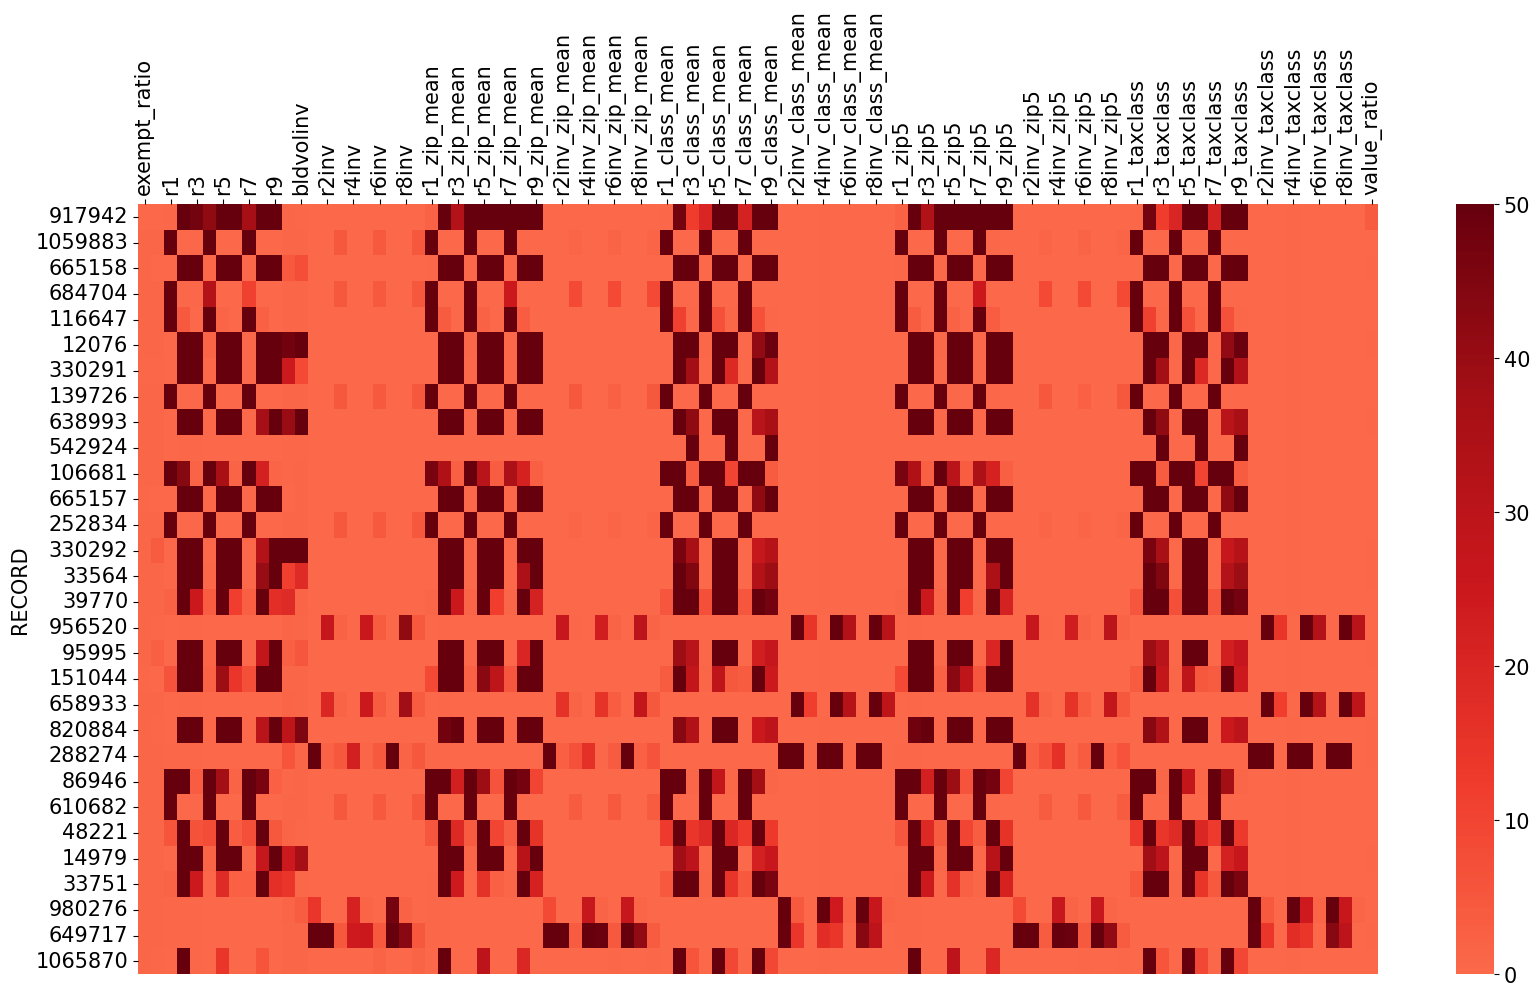

In [361]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [362]:
top_records_df = pd.DataFrame(top_records)

In [363]:
# # Use this cell if you want to write out the top n record numbers
# top_records_df.to_csv('top_10000_record_numbers.csv', index=False)

In [364]:
# Use this cell if you want to compare to a previous top n record numbers.
# You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# to see what % of these top scoring records change. The top records are insensitive to changes in the 
# powers for the Minkowski distance measures for the two scores
file_name = 'top_{n}_record_numbers.csv'.format(n = ntop)

top_records_previous = pd.read_csv(file_name)
print(top_records_df.head())
print(top_records_previous.head())
num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
percent_common = 100*num_common/ntop
percent_common

    RECORD
0   917942
1  1059883
2   665158
3   684704
4   116647
    RECORD
0   917942
1  1059883
2   684704
3   665158
4   116647


96.07

In [365]:
# about 4 minutes
print('Duration: ', datetime.now() - start_time)

Duration:  0:19:26.210301
